In [1]:
import pandas as pd
import pickle
from pathlib import Path
from collections import namedtuple
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
%matplotlib inline

# Display more rows and get rid of the margins
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth',500)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Display mulitiple values from each cell
# https://stackoverflow.com/a/42476224
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [9]:
ModPermRes = namedtuple("ModPermRes",['pn','fn','name', 'clf', 'ho_score','cfn'])
VarPermRes = namedtuple("VarPermRes", ["pn", "metric", "int_r2", "agh_r2", "aghs_r2", "aghss_r2", "aghsss_r2"])

In [10]:
res_dir = Path('/data/nielsond/abcd/nielson_abcd_2018/release11_tfmri')

In [11]:
con_pks = sorted(list(res_dir.glob('*_con.pkz')))
crt_pks = sorted(list(res_dir.glob('*_crt_*.pkz')))

In [12]:
def get_pn(perm_pkz):
    return int(perm_pkz.parts[-1].split('_')[0].split('-')[1])

def get_crt(perm_pkz):
    pn = int(perm_pkz.parts[-1].split('_')[0].split('-')[1])
    task = perm_pkz.parts[-1].split('_')[2]
    contrast = perm_pkz.parts[-1].split('_')[3]
    run = perm_pkz.parts[-1].split('_')[4]
    return pn, task, contrast, run

def get_varex(df):
    df['agh_varex'] = (df.agh_r2 - df.int_r2) * 100
    df['mfg_varex'] = (df.aghs_r2 - df.agh_r2) * 100
    df['model_varex'] = (df.aghss_r2 - df.aghs_r2) * 100
    df['site_varex'] = (df.aghsss_r2 - df.aghss_r2) * 100
    return df

def adjr2_to_r2(y, n, p):
    res = (((n - 1) * y) + (p * (-1 * y)) + p)/ (n - 1)
    return res

def get_unadj_r2(df, n):
    df['int_r2'] = adjr2_to_r2(df.int_r2, n, 1)
    df['agh_r2'] = adjr2_to_r2(df.agh_r2, n, 4)
    df['aghs_r2'] = adjr2_to_r2(df.aghs_r2, n, 5)
    df['aghss_r2'] = adjr2_to_r2(df.aghss_r2, n, 6)
    df['aghsss_r2'] = adjr2_to_r2(df.aghsss_r2, n, 7)
    return df

# Task based

In [7]:
bad_files = []
crt_mod_res = []
crt_var_res = []
crt_cb_var_res = []
print("Pickles to load: ", len(crt_pks))
for ii, pk in enumerate(crt_pks):
    pn, task, contrast, run = get_crt(pk)
    try:
        with open(pk, 'rb') as h:
            pkr = pickle.load(h)
    except EOFError:
        print('BAD FILE:', pk)
        bad_files.append(pk)
        continue
    mod_res_cols = ['pn', 'fn', 'name', 'ho_score', 'cfn', 'coef']
    tmp_mod = pd.DataFrame(pkr[0])
    tmp_mod['coef'] = [clf.coef_ for clf in tmp_mod.clf]
    crt_mod_res.append(tmp_mod.loc[:,mod_res_cols].assign(**{'task': task, 'contrast':contrast, 'run':run}))
    crt_var_res.append(pd.DataFrame(pkr[1]).assign(**{'task': task, 'contrast':contrast, 'run':run}))
    crt_cb_var_res.append(pd.DataFrame(pkr[2]).assign(**{'task': task, 'contrast':contrast, 'run':run}))
    if ii % 500 == 0:
        print(ii, task, contrast, run, pn, flush=True)
        
crt_mod_res = pd.concat(crt_mod_res)
crt_var_res = pd.concat(crt_var_res)
crt_cb_var_res = pd.concat(crt_cb_var_res)

Pickles to load:  5252


/data/nielsond/python/envs/mriqc/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


0 mid antic.large.loss.vs.neutral run1.pkz 0
500 nback negface.vs.neutface run1.pkz 9
1000 mid antic.small.loss.vs.neutral run1.pkz 19
1500 sst correct.stop.vs.incorrect.stop run1.pkz 28
2000 nback 2.back run1.pkz 38
2500 mid antic.large.vs.small.loss run1.pkz 48
3000 nback posface.vs.neutface run1.pkz 57
3500 mid loss.pos.vs.neg.feedback run1.pkz 67
4000 sst incorrect.go.vs.incorrect.stop run1.pkz 76
4500 nback emotion run1.pkz 86
5000 mid antic.loss.vs.neutral run1.pkz 96


In [19]:
crt_mod_res['label'] = crt_mod_res.contrast + crt_mod_res.run
crt_mod_res = crt_mod_res.reset_index(drop=True)

In [14]:
# Save results to consolidated pickles
crt_mod_res.to_pickle('crt_mod_seperate_1000_beta.pkz')
#crt_var_res.to_pickle('crt_var_res_seperate_1000.pkz')
#crt_cb_var_res.to_pickle('crt_cb_var_res_seperate_1000.pkz')

In [ ]:
crt_mod_res = pd.read_pickle('crt_mod_100.pkz')
crt_var_res = pd.read_pickle('crt_var_res_100.pkz')
crt_cb_var_res = pd.read_pickle('crt_cb_var_res_100.pkz')

In [20]:
expected_pns = set(crt_mod_res.query('label == "antic.large.loss.vs.neutralrun1.pkz"').pn.unique())
print(len(expected_pns))

101


In [21]:
missing_ps = {}
for x,df in crt_mod_res.groupby('label'):
    found_pns = set(df.pn.unique())
    if len(found_pns) < len(expected_pns):
        missing_ps[x]=expected_pns.difference(found_pns)


In [22]:
crt_mod_res.pn.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [23]:
crt_mod_res.groupby(['label']).pn.nunique()


label
0.backrun1.pkz                            101
0.backrun2.pkz                            101
2.back.vs.0.backrun1.pkz                  101
2.back.vs.0.backrun2.pkz                  101
2.backrun1.pkz                            101
2.backrun2.pkz                            101
antic.large.loss.vs.neutralrun1.pkz       101
antic.large.loss.vs.neutralrun2.pkz       101
antic.large.reward.vs.neutralrun1.pkz     101
antic.large.reward.vs.neutralrun2.pkz     101
antic.large.vs.small.lossrun1.pkz         101
antic.large.vs.small.lossrun2.pkz         101
antic.large.vs.small.rewardrun1.pkz       101
antic.large.vs.small.rewardrun2.pkz       101
antic.loss.vs.neutralrun1.pkz             101
antic.loss.vs.neutralrun2.pkz             101
antic.reward.vs.neutralrun1.pkz           101
antic.reward.vs.neutralrun2.pkz           101
antic.small.loss.vs.neutralrun1.pkz       101
antic.small.loss.vs.neutralrun2.pkz       101
antic.small.reward.vs.neutralrun1.pkz     101
antic.small.reward.vs.neutra

In [24]:
n_cr = len(crt_mod_res.label.unique())
complete_perms = (crt_mod_res.groupby('pn').label.nunique()==n_cr)
complete_perms = complete_perms[complete_perms].index.values

In [55]:
def make_bar_list(factors, to_plot, to_plot_sig, group_offset=1.5, left_start=0, cols = 2,
                  sig_palette=sns.color_palette('muted6'), palette=sns.color_palette('pastel6'),
                  error=None, group_var=None, sig_exclude=[],
                  stack=True):
    fplist = []
    left = np.zeros(len(to_plot)) + left_start
    height = 0.8
    if not stack:
        height /= len(factors)
    for i,vf in enumerate(factors):
        fdict = {'bottom': [], 'width': [], 'left':left.copy(), 'color':[], 'label': [], 'tick_label': [], 'height':height}
        if error is not None:
            fdict['xerr'] = []
        if group_var is not None:
            fdict[group_var] = []
        yoffset=0

        if group_var is not None:
            for x,df in to_plot.groupby(group_var):
                if not stack:
                    fdict['bottom'].extend(list(np.arange(len(df)) + yoffset + height * i))
                else:
                    fdict['bottom'].extend(list(np.arange(len(df)) + yoffset))
                fdict['width'].extend(list(df[vf].values))
                fdict['tick_label'].extend(list(df.label.values))
                yoffset += len(df)+group_offset
                if group_var is not None:
                    fdict[group_var].extend(list(df[group_var].values))
                labels = np.array([vf]*len(df))
                colors = np.array([palette[i]]*len(df))
                
                if vf not in sig_exclude:
                    sig_mask = df[vf].values >= to_plot_sig[vf]
                    labels[sig_mask] = 'Sig. ' + vf
                    colors[sig_mask] = sig_palette[i]
                fdict['color'].extend(list(colors))
                fdict['label'].extend(list(labels))
                if error is not None:
                    fdict['xerr'].extend(list(df[error[i]].values))
        else:
            df = to_plot
            if not stack:
                fdict['bottom'].extend(list(np.arange(len(df)) + yoffset + height * i))
            else:
                fdict['bottom'].extend(list(np.arange(len(df)) + yoffset))
            fdict['width'].extend(list(df[vf].values))
            fdict['tick_label'].extend(list(df.label.values))
            if error is not None:
                fdict['xerr'].extend(list(df[error[i]].values))
            yoffset += len(df)+group_offset
            if group_var is not None:
                fdict[group_var].extend(list(df[group_var].values))
            labels = np.array([vf]*len(df))
            colors = np.array([palette[i]]*len(df))
            if vf not in sig_exclude:
                sig_mask = df[vf].values >= to_plot_sig[vf]
                labels[sig_mask] = 'Sig. ' + vf
                colors[sig_mask] = sig_palette[i]
            fdict['color'].extend(list(colors))
            fdict['label'].extend(list(labels))
        

        fdict['width'] = np.array(fdict['width'])
        fdict['width'][fdict['width']<0] = 0

        fdf = pd.DataFrame(fdict)
        fdf['col'] = cols - 1 - pd.cut(fdf['bottom'], cols, labels = np.arange(cols)).astype(int)
        if group_var is not None:
            fdf = fdf.merge(pd.DataFrame(fdf.groupby(group_var).col.max()).reset_index(), on=group_var, suffixes=['_bad','']).drop('col_bad', axis=1)
        fplist.append(fdf)
        yoffset += group_offset
        if stack:
            left += np.array(fdict['width'])
    return fplist

In [56]:
crt_mod_to_plot = crt_mod_res.groupby(['task', 'contrast','run', 'pn', 'name'])[['ho_score']].agg(['mean' ,'std']).query('pn == 0').reset_index()
crt_mod_to_plot.columns = [' '.join(col).strip() for col in crt_mod_to_plot.columns.values]
crt_mod_to_plot = crt_mod_to_plot.drop('pn', axis=1)
crt_mod_to_plot['ho_score std'] *= 100
crt_mod_to_plot['ho_score mean'] *= 100
crt_mod_to_plot['task'] = crt_mod_to_plot.task.str.upper()
crt_mod_to_plot['label'] = ''

crt_mod_to_plot.loc[~crt_mod_to_plot.contrast.str.contains('vs'), 'label'] = (crt_mod_to_plot
                                                                              .contrast
                                                                              .str.split('.')
                                                                              .str.join(' ')
                                                                              .str.title()) + '* ' + crt_mod_to_plot.run.str.split('.').str[0].str[-1]
crt_mod_to_plot.loc[crt_mod_to_plot.contrast.str.contains('vs'), 'label'] =(crt_mod_to_plot
                                                                             .contrast
                                                                             .str.replace('fixation', 'Fix')
                                                                             .str.replace('reward', 'Rewd')
                                                                             .str.replace('small', 'Sm')
                                                                             .str.replace('large', 'Lg')
                                                                             .str.replace('neutral', 'Neut')
                                                                             .str.replace('positive', 'Pos')
                                                                             .str.replace('negative', 'Neg')
                                                                             .str.replace('antic', 'Ant')
                                                                             .str.replace('-any', '')
                                                                             .str.replace('correct', 'cor')
                                                                             .str.replace('-of', '')
                                                                             .str.replace('feedback', 'FB')
                                                                             .str.split('.')
                                                                             .str.join(' ')
                                                                             .str.title()
                                                                             .str.replace('Vs', 'v')) + ' ' + crt_mod_to_plot.run.str.split('.').str[0].str[-1]
crt_mod_to_plot['task'] = crt_mod_to_plot.replace('NBACK', 'nBack')

In [57]:
mod_names = ['normal', 'age_rsd']
cb_mod_names = ['combat', 'cbagersd']

In [58]:
wide_df = (crt_mod_to_plot.query('name == @mod_names[0]')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":mod_names[0], "ho_score std":mod_names[0]+"_std"})
                          .drop("name", axis=1))
for name in mod_names[1:]:
    tmp = (crt_mod_to_plot.query('name == @name')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":name, "ho_score std":name+"_std"})
                          .drop("name", axis=1))
    wide_df = wide_df.merge(tmp, how='left', on=['task', 'contrast', 'run', 'label'])
    
cb_wide_df = (crt_mod_to_plot.query('name == @cb_mod_names[0]')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":cb_mod_names[0], "ho_score std":cb_mod_names[0]+"_std"})
                          .drop("name", axis=1))
for name in cb_mod_names[1:]:
    tmp = (crt_mod_to_plot.query('name == @name')
                          .reset_index(drop=True)
                          .rename(columns={"ho_score mean":name, "ho_score std":name+"_std"})
                          .drop("name", axis=1))
    cb_wide_df = cb_wide_df.merge(tmp, how='left', on=['task', 'contrast', 'run', 'label'])

In [59]:
alpha = 0.02
sig_thresh = {'normal': 100*crt_mod_res.groupby(['name', 'pn','contrast','run'])[['ho_score']].mean().reset_index().query('name in @mod_names').groupby( ['pn'])[['ho_score']].max().quantile([1-alpha]).values[0][0]}
sig_thresh['combat'] =  100*crt_mod_res.groupby(['name', 'pn','contrast','run'])[['ho_score']].mean().reset_index().query('name in @cb_mod_names').groupby( ['pn'])[['ho_score']].max().quantile([1-alpha]).values[0][0]
sig_thresh['age_rsd'] = sig_thresh['normal']
sig_thresh['cbagersd'] = sig_thresh['combat']

In [60]:
sig_thresh

{'normal': 11.147768595041327,
 'combat': 10.550633608815426,
 'age_rsd': 11.147768595041327,
 'cbagersd': 10.550633608815426}

In [61]:
cb_sig_thresh = {'combat': 100*crt_mod_res.groupby(['name', 'pn','contrast','run'])[['ho_score']].mean().reset_index().query('name in @cb_mod_names').groupby( ['pn'])[['ho_score']].max().quantile([1-alpha]).values[0][0]}
cb_sig_thresh['cbagersd'] = cb_sig_thresh['combat']

In [62]:
sig_thresh, cb_sig_thresh

({'normal': 11.147768595041327,
  'combat': 10.550633608815426,
  'age_rsd': 11.147768595041327,
  'cbagersd': 10.550633608815426},
 {'combat': 10.550633608815426, 'cbagersd': 10.550633608815426})

In [63]:
wide_df = wide_df.rename(columns={'contrast':'metric'})
cb_wide_df = cb_wide_df.rename(columns={'contrast':'metric'})

In [167]:
secondaxis_start=35
uncorlist = make_bar_list(mod_names, wide_df, sig_thresh, cols = 3, error=[mn + '_std' for mn in mod_names], group_var='task', stack=False)
cblist = make_bar_list(cb_mod_names, cb_wide_df, sig_thresh, left_start = secondaxis_start, cols = 3, error=[mn + '_std' for mn in cb_mod_names], group_var='task', stack=False)

### Calculate significant reductions in classifiability 

In [168]:
t_res = []
for label, label_df in crt_mod_res.groupby('label'):
    for mn, cn in zip(mod_names, cb_mod_names):
        m_res =  label_df.query('name == @mn').loc[:,['pn','fn','ho_score']]
        cb_res = label_df.query('name == @cn').loc[:,['pn','fn','ho_score']]
        m_res = m_res.merge(cb_res, how='left', on=['pn','fn'], suffixes=('', '_cb'))
        for x,df in m_res.groupby('pn'):
            t,p = stats.ttest_ind(df.ho_score, df.ho_score_cb, equal_var=False)
            t_res.append({'mn':mn,'pn':x, 't':t, 'p':p, 'label': label})

t_res = pd.DataFrame(t_res)
t_res['t_abs'] = np.abs(t_res.t)
nullt = t_res.groupby('pn').t_abs.max()
t_res['t_abs'] = np.abs(t_res.t)


In [169]:
cb_reduce_sig = t_res.query('pn==0').t_abs.apply(lambda x:(x<=nullt).mean())*2
cb_reduce_sig = pd.DataFrame(cb_reduce_sig).rename(columns={'t_abs': 'perm_p'})
cb_reduce_sig = cb_reduce_sig.merge(t_res.query('pn==0').loc[:,['label', 'mn']], how = 'left', right_index=True, left_index=True)
cb_reduce_sig = cb_reduce_sig.merge(crt_mod_res.query('pn==0 & fn==0 & name=="normal"').loc[:,['contrast', 'run', 'label']], how='left', on=['label']).rename(columns={'mn':'name'})

In [170]:
crt_mod_to_plot = crt_mod_to_plot.merge(cb_reduce_sig.loc[:,['perm_p', 'name', 'contrast', 'run']], how='left', on=['contrast', 'run', 'name'])

In [171]:
t_res = pd.DataFrame(t_res)
t_res['t_abs'] = np.abs(t_res.t)
#t_res.query('pn==0').t_abs.apply(lambda x:(x<=t_res.groupby( ['pn'])[['t_abs']].max().values).mean())

In [172]:

plot_range = (uncorlist[0].groupby('col').bottom.max() - uncorlist[0].groupby('col').bottom.min()).max()

<BarContainer object of 4 artists>

 <BarContainer object of 4 artists>]

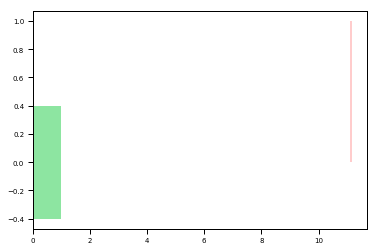

In [173]:
fig,ax = plt.subplots(1)
sig_palette=sns.color_palette('muted6')[0:len(mod_names)]
palette=sns.color_palette('pastel6')[0:len(mod_names)]
bottom = np.zeros(len(mod_names)*2)
width = np.ones(len(mod_names)*2)
leg_labels = []
colors = []
for i,vf in enumerate(mod_names):
    colors.append(sig_palette[i])
    leg_labels.append('Sig. '+vf)
    leg_labels.append(vf)
    colors.append(palette[i])
ax.barh(bottom, width, color=colors, label=['Sig. Sex, Hand Bal.', 'Sex, Hand Bal.','Sig. Sex, Hand Bal., Age Regressed', 'Sex, Hand Bal., Age Regressed' ])
ax.vlines(sig_thresh['normal'], 0,2-1, colors = 'r', lw=0.4, label='Multiple Comparison\nCorrected p<0.01')
leg_hand, leg_labels = ax.get_legend_handles_labels()
leg_hand
handles = []
handles.extend(leg_hand[1])
handles.append(leg_hand[0])

labels = ['Sig. Sex, Hand Bal.', 'Sex, Hand Bal.','Sig. Sex, Hand Bal., Age Regressed', 'Sex, Hand Bal., Age Regressed' ]
labels.append(leg_labels[0])

/data/nielsond/python/envs/mriqc/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
  from ipykernel import kernelapp as app
/data/nielsond/python/envs/mriqc/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
  app.launch_new_instance()
/data/nielsond/python/envs/mriqc/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bottom* will be removed in Matplotlib 3.0
  from ipykernel import kernelapp as app
/data/nielsond/python/envs/mriqc/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The *bottom* kwarg to `barh` is deprecated use *y* instead. Support for *bott

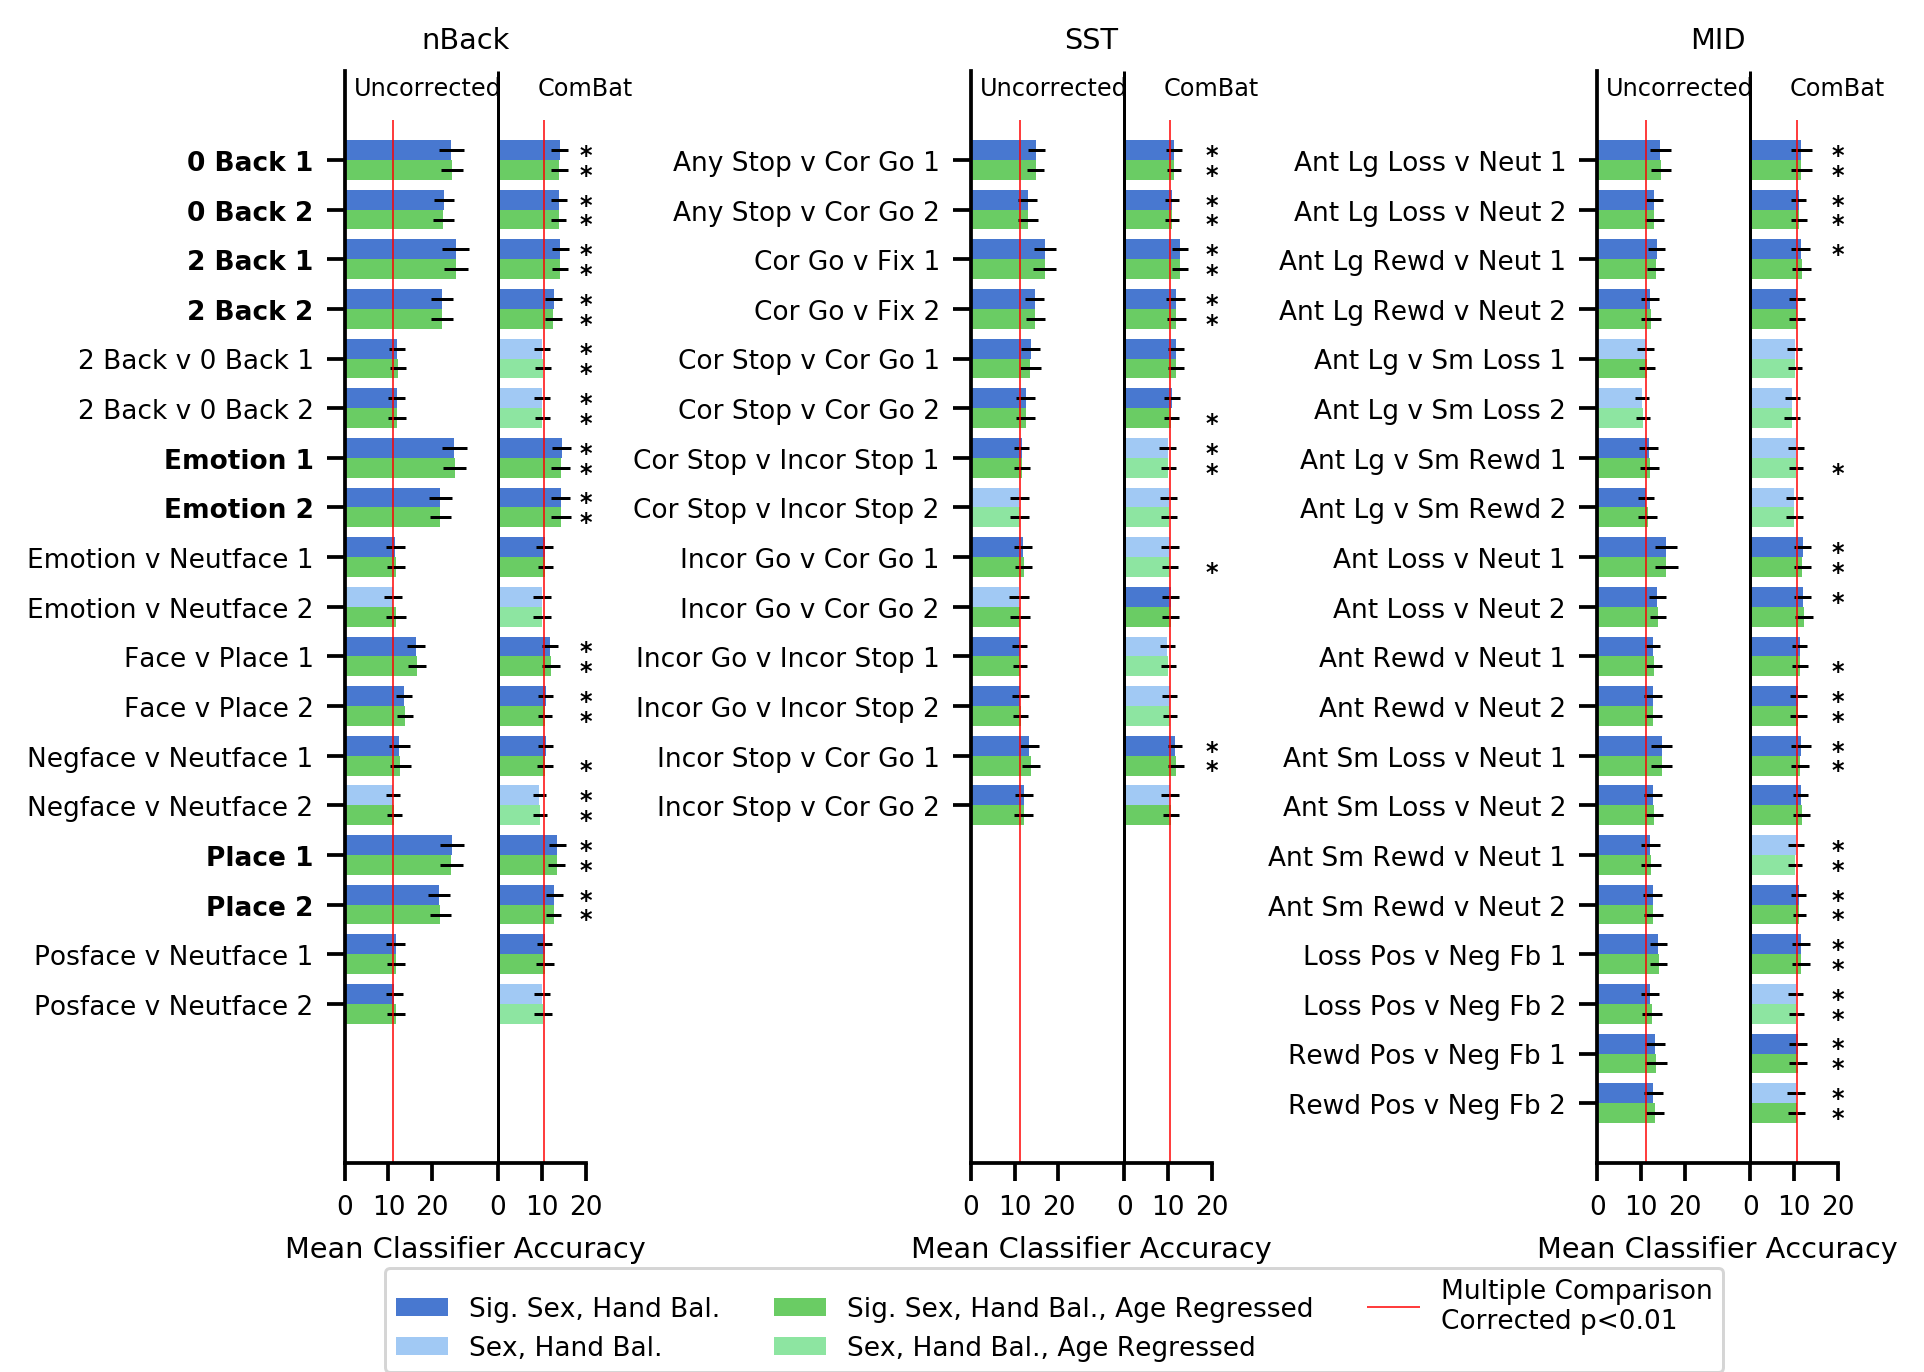

In [176]:
sns.set_context('paper', font_scale=0.8)
fig, axes = plt.subplots(1, 3, figsize=(7,5), dpi=270)

for col in np.arange(len(axes)):
    ax = axes[col]
    for uc, cb in zip(uncorlist, cblist):
        uc = uc.copy()
        cb = cb.copy()
        uc.bottom = 0 - uc.bottom
        cb.bottom = 0 - cb.bottom
        barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'tick_label', 'width', 'height', 'xerr']].to_dict('list')
        cb_barh_dict = cb.loc[cb.col == col, ['bottom', 'color', 'left', 'tick_label', 'width', 'height', 'xerr']].to_dict('list')
        
        names = uc.loc[uc.col == col, ['task']]
        _plot = ax.barh(**barh_dict, error_kw={'elinewidth':0.8})
        _plot = ax.barh(**cb_barh_dict, error_kw={'elinewidth':0.8})
    name_df = uc.loc[uc.col == col, ['bottom', 'task']].groupby('task').max().reset_index()
    #for ii, row in name_df.iterrows():
    #    _text = ax.text(11, row.bottom + 1, row.metric, va='bottom', ha='center')
    yb,yt = ax.get_ylim()
    _ylims = ax.set_ylim((np.max(barh_dict['bottom'])-plot_range-1, np.max(barh_dict['bottom'])+2))
    yb,yt = ax.get_ylim()
    _vl = ax.vlines(secondaxis_start, yb,yt, lw=0.8)
    _vl = ax.vlines(sig_thresh['normal'], yb,yt-1, colors = 'r', lw=0.4)
    _vl = ax.vlines(secondaxis_start+cb_sig_thresh['combat'], yb,yt-1, colors = 'r', lw=0.4)

    _lim = ax.set_ylim((yb,yt))
    t = ax.set_xticks([0,10,20,secondaxis_start, secondaxis_start+10, secondaxis_start+20])
    _tl = ax.set_xticklabels([0,10,20,0, 10, 20])
    _ylims = ax.set_ylim((yb, yt))
    _t = ax.text(2, yt-0.5, 'Uncorrected', fontsize='small')
    _t = ax.text(44, yt-0.5, 'ComBat', fontsize='small')
    _t = ax.set_title(name_df.task.values[0])
    _t = ax.set_xlabel('Mean Classifier Accuracy')
    _yt = ax.set_yticks(uc.loc[uc.col == col, 'bottom'] + uc.loc[uc.col == col, 'height'] / 2)
    
# Make Condition labels bold
new_labels = []
for tl in axes[0].get_yticklabels():
    txt = tl.get_text()
    if '*' in txt:
        _tl = tl.set_weight('bold')
        txt = txt.replace('*', '')
    new_labels.append(txt)
_tl = axes[0].set_yticklabels(new_labels)
#for tl in axes[0].get_yticklabels():
#    print(tl.get_text())
fig.tight_layout()
_leg = fig.legend(handles, labels, loc=(0.2,0), ncol=3 )    
fig.subplots_adjust(bottom = 0.135)

# Add *'s to sig reductions
for uc in uncorlist:
    if 'normal' in uc.label.values:
        sig_reduced = crt_mod_to_plot.query('name=="normal"').loc[:, ['label', 'perm_p']]
    elif 'age_rsd' in uc.label.values:
        sig_reduced = crt_mod_to_plot.query('name=="age_rsd"').loc[:, ['label', 'perm_p']]
    tmp = uc.merge(sig_reduced, how='left', left_on='tick_label', right_on='label')
    tmp = tmp.query('perm_p< 0.02')
    for col, df in tmp.groupby('col'):
        ax = axes[col]
        for yval in (df.bottom):
            _s = ax.text(secondaxis_start+20, 0-yval-0.1, '*', va='center', ha='center', fontweight='bold', fontsize='small')
        

sns.despine(fig)

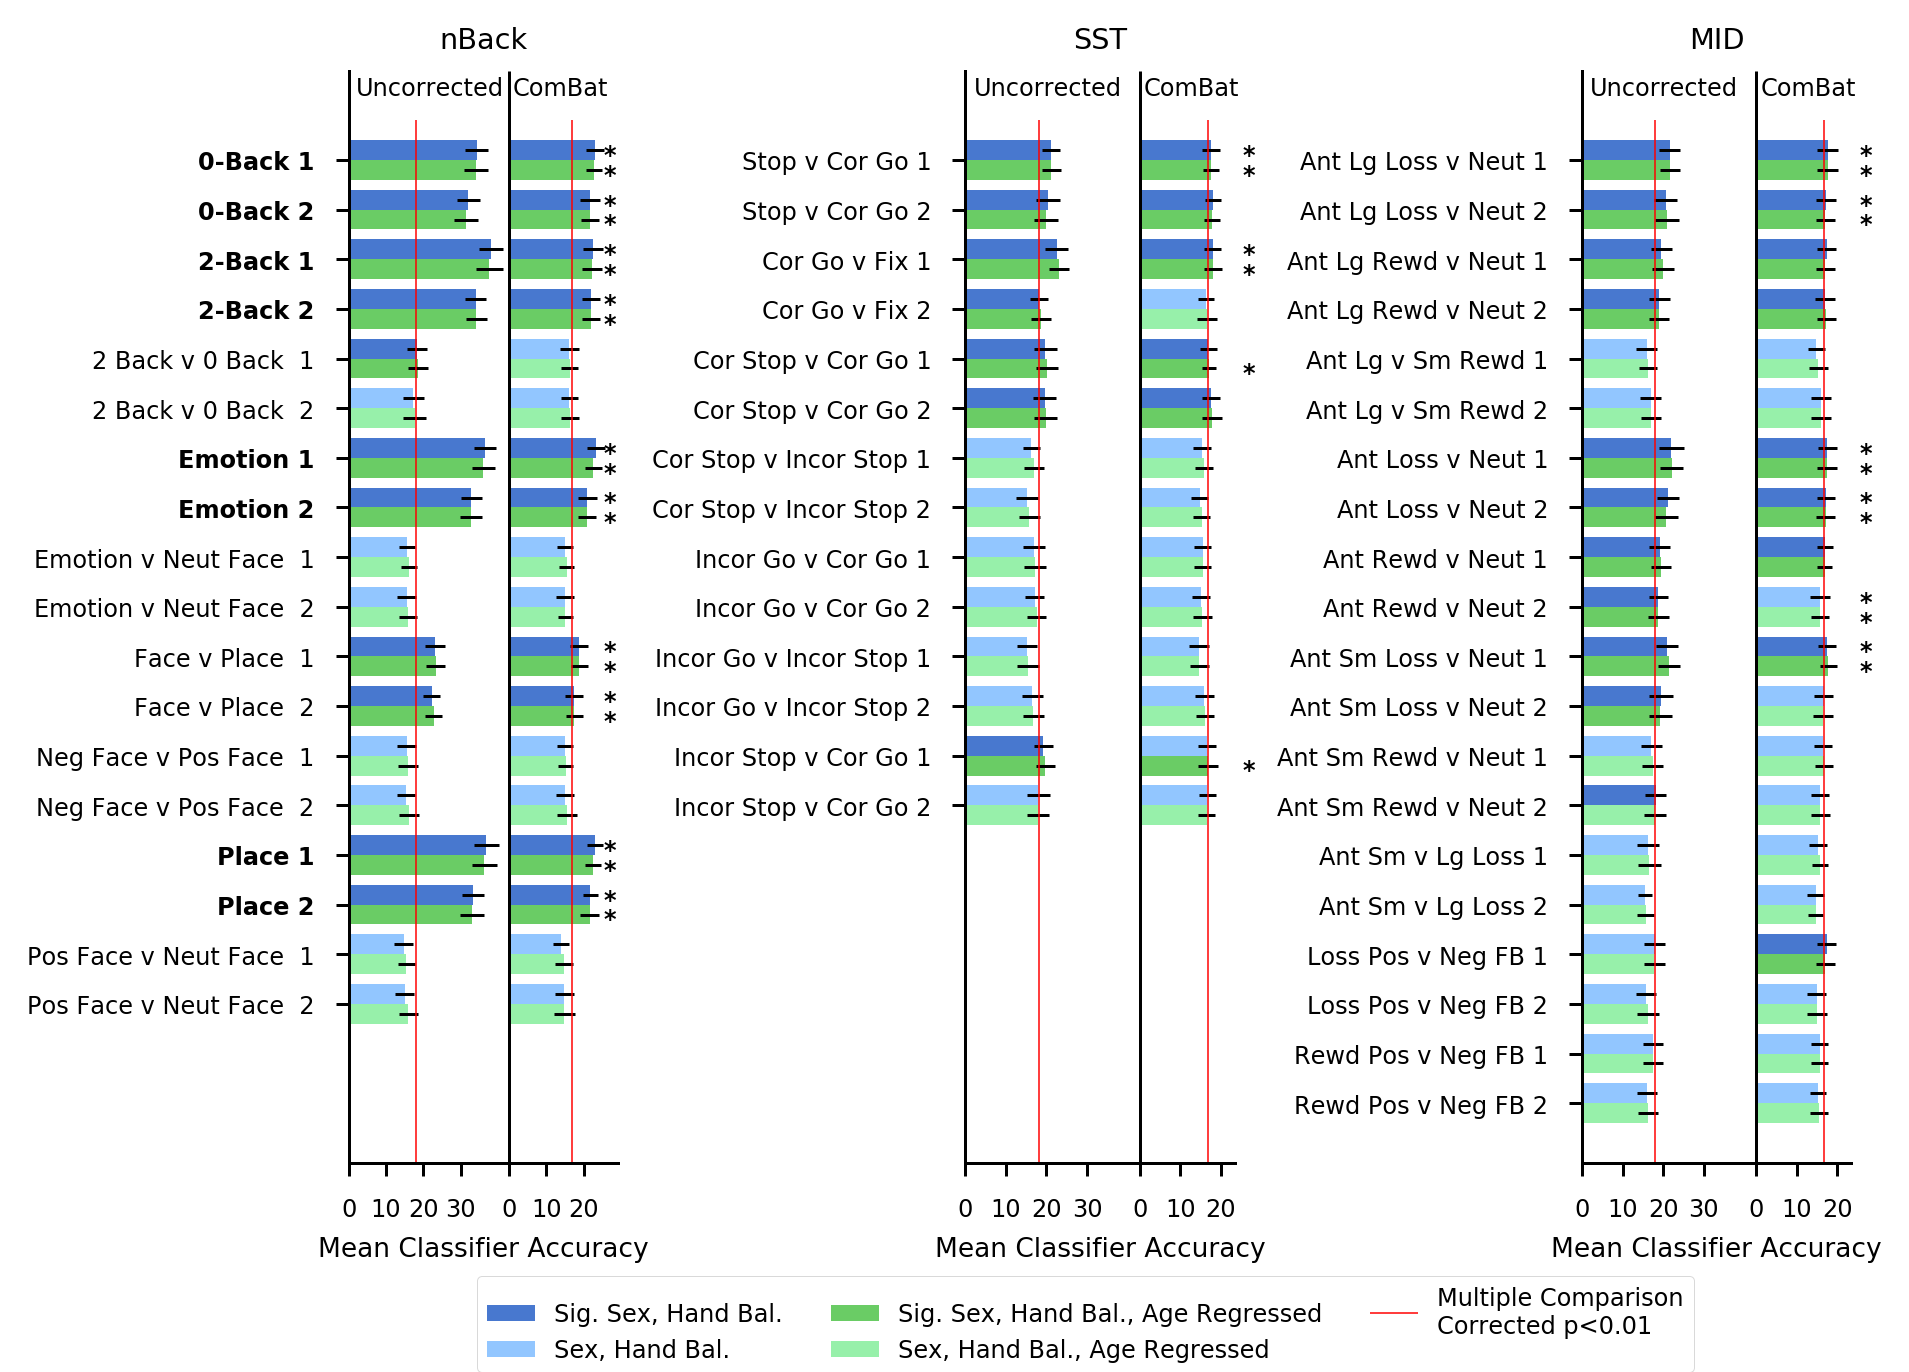

In [764]:
sns.set_context('paper', font_scale=0.8)
fig, axes = plt.subplots(1, 3, figsize=(7,5), dpi=270)

for col in np.arange(len(axes)):
    ax = axes[col]
    for uc, cb in zip(uncorlist, cblist):
        uc = uc.copy()
        cb = cb.copy()
        uc.bottom = 0 - uc.bottom
        cb.bottom = 0 - cb.bottom
        barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'tick_label', 'width', 'height', 'xerr']].to_dict('list')
        cb_barh_dict = cb.loc[cb.col == col, ['bottom', 'color', 'left', 'tick_label', 'width', 'height', 'xerr']].to_dict('list')
        
        names = uc.loc[uc.col == col, ['task']]
        _plot = ax.barh(**barh_dict, error_kw={'elinewidth':0.8})
        _plot = ax.barh(**cb_barh_dict, error_kw={'elinewidth':0.8})
    name_df = uc.loc[uc.col == col, ['bottom', 'task']].groupby('task').max().reset_index()
    #for ii, row in name_df.iterrows():
    #    _text = ax.text(11, row.bottom + 1, row.metric, va='bottom', ha='center')
    yb,yt = ax.get_ylim()
    _ylims = ax.set_ylim((np.max(barh_dict['bottom'])-plot_range-1, np.max(barh_dict['bottom'])+2))
    yb,yt = ax.get_ylim()
    _vl = ax.vlines(43, yb,yt, lw=0.8)
    _vl = ax.vlines(sig_thresh['normal'], yb,yt-1, colors = 'r', lw=0.4)
    _vl = ax.vlines(43+cb_sig_thresh['combat'], yb,yt-1, colors = 'r', lw=0.4)

    _lim = ax.set_ylim((yb,yt))
    t = ax.set_xticks([0,10,20,30,43, 53, 63])
    _tl = ax.set_xticklabels([0,10,20,30,0, 10, 20])
    _ylims = ax.set_ylim((yb, yt))
    _t = ax.text(2, yt-0.5, 'Uncorrected', fontsize='small')
    _t = ax.text(44, yt-0.5, 'ComBat', fontsize='small')
    _t = ax.set_title(name_df.task.values[0])
    _t = ax.set_xlabel('Mean Classifier Accuracy')
    _yt = ax.set_yticks(uc.loc[uc.col == col, 'bottom'] + uc.loc[uc.col == col, 'height'] / 2)
    
# Make Condition labels bold
new_labels = []
for tl in axes[0].get_yticklabels():
    txt = tl.get_text()
    if '*' in txt:
        _tl = tl.set_weight('bold')
        txt = txt.replace('*', '')
    new_labels.append(txt)
_tl = axes[0].set_yticklabels(new_labels)
#for tl in axes[0].get_yticklabels():
#    print(tl.get_text())
fig.tight_layout()
_leg = fig.legend(handles, labels, loc=(0.25,0), ncol=3 )    
fig.subplots_adjust(bottom = 0.135)

# Add *'s to sig reductions
for uc in uncorlist:
    if 'normal' in uc.label.values:
        sig_reduced = crt_mod_to_plot.query('name=="normal"').loc[:, ['label', 'perm_p']]
    elif 'age_rsd' in uc.label.values:
        sig_reduced = crt_mod_to_plot.query('name=="age_rsd"').loc[:, ['label', 'perm_p']]
    tmp = uc.merge(sig_reduced, how='left', left_on='tick_label', right_on='label')
    tmp = tmp.query('perm_p< 0.002')
    for col, df in tmp.groupby('col'):
        ax = axes[col]
        for yval in (df.bottom):
            _s = ax.text(70, 0-yval-0.1, '*', va='center', ha='center', fontweight='bold', fontsize='small')
        

sns.despine(fig)

In [581]:
crt_mod_res['label'] = crt_mod_res.contrast + crt_mod_res.run

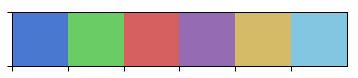

In [74]:
sns.palplot(sns.color_palette('muted6'))


In [31]:
import itertools

In [173]:
def all_ts(df):
    dat = df.pivot(index='fn',columns='label', values='ho_score').values
    tmp = []
    for a,b in itertools.combinations(dat.T, 2):
        tmp.append(stats.ttest_rel(a,b)[0])
    return np.max(np.abs(tmp))

In [175]:
all_t_df = crt_mod_res.groupby(['pn', 'name']).apply(all_ts)

In [176]:
# all ts threshold
ts_threshold = pd.DataFrame(all_t_df).query('name in @mod_names').groupby('pn').max().quantile(0.999)[0]
ts_threshold

14.307118657187166

In [177]:
vsig_conds = crt_mod_res.groupby(['name', 'pn','contrast','run'])[['ho_score']].mean().query('pn == 0 & ho_score > 0.3 & name == "normal"').reset_index().contrast.unique()
sig_thresh_norm = sig_thresh["normal"]/100
sig_conds = crt_mod_res.groupby(['name', 'pn','contrast','run'])[['ho_score']].mean().query('pn == 0 & ho_score < 0.3 & ho_score > @sig_thresh_norm & name == "normal"').reset_index().contrast.unique()
nsig_conds = crt_mod_res.groupby(['name', 'pn','contrast','run'])[['ho_score']].mean().query('pn == 0 & ho_score < @sig_thresh_norm & name == "normal"').reset_index().contrast.unique()

In [178]:
conds = crt_mod_res.query('pn == 0 & name == "normal" & contrast in @vsig_conds').pivot(index='fn',columns='label', values='ho_score').values
ctrs = crt_mod_res.query('pn == 0 & name == "normal" & ~(contrast in @vsig_conds)').pivot(index='fn',columns='label', values='ho_score').values

res = []
for o in conds.T:
    for t in ctrs.T:
        res.append(stats.ttest_rel(o,t)[0])
        
# Minimum pairwise t between vsig and any other condition
np.min(np.abs(res))

18.012272795308867

In [179]:
crt_var_res = get_unadj_r2(crt_var_res, 1065)
crt_cb_var_res = get_unadj_r2(crt_cb_var_res, 1065)
crt_var_res = get_varex(crt_var_res)
crt_cb_var_res = get_varex(crt_cb_var_res)

In [180]:
crt_var_res_to_plot = crt_var_res.merge(crt_cb_var_res.query('pn == 0').loc[:,['pn','metric','task','contrast', 'run','agh_varex','mfg_varex','model_varex','site_varex']], on = ['pn','metric', 'task','contrast','run'], suffixes=('','_cb'))

In [181]:
sig_thresh_norm

0.18083926109734819

In [182]:
vsig_conds
sig_conds
nsig_conds

array(['nBack-0-back-condition', 'nBack-2-back-condition',
       'nBack-emotion-condition', 'nBack-place-condition'], dtype=object)

array(['MID-anticipation-of-large-loss-versus-neutral',
       'MID-anticipation-of-large-reward-versus-neutral',
       'MID-anticipation-of-loss-versus-neutral',
       'MID-anticipation-of-reward-versus-neutral',
       'MID-anticipation-of-small-loss-versus-neutral',
       'MID-anticipation-of-small-reward-versus-neutral',
       'SST-any-stop-versus-correct-go', 'SST-correct-go-versus-fixation',
       'SST-correct-stop-versus-correct-go',
       'SST-incorrect-stop-versus-correct-go',
       'nBack-2-back-versus-0-back-contrast',
       'nBack-face-versus-place-contrast'], dtype=object)

array(['MID-anticipation-of-large-versus-small-reward',
       'MID-anticipation-of-small-reward-versus-neutral',
       'MID-anticipation-of-small-versus-large-loss',
       'MID-loss-positive-versus-negative-feedback',
       'MID-reward-positive-versus-negative-feeback',
       'SST-correct-stop-versus-incorrect-stop',
       'SST-incorrect-go-versus-correct-go',
       'SST-incorrect-go-versus-incorrect-stop',
       'SST-incorrect-stop-versus-correct-go',
       'nBack-2-back-versus-0-back-contrast',
       'nBack-emotion-versus-neutral-face-contrast',
       'nBack-negative-face-versus-positive-face-contrast',
       'nBack-positive-face-versus-neutral-face-contrast'], dtype=object)

In [183]:
mean_cond_var = crt_var_res_to_plot.loc[crt_var_res_to_plot.contrast.isin(vsig_conds), :]
mean_cond_var = mean_cond_var.merge(crt_var_res_to_plot.loc[crt_var_res_to_plot.contrast.isin(vsig_conds), :].groupby('metric')[['site_varex']].mean().reset_index(), how = 'left', on='metric', suffixes=('', '_mean')) 

mean_cnt_var = crt_var_res_to_plot.loc[crt_var_res_to_plot.contrast.isin(sig_conds), :]
mean_cnt_var = mean_cnt_var.merge(crt_var_res_to_plot.loc[crt_var_res_to_plot.contrast.isin(sig_conds), :].groupby('metric')[['site_varex']].mean().reset_index(), how = 'left', on='metric', suffixes=('', '_mean')) 

mean_ns_var = crt_var_res_to_plot.loc[crt_var_res_to_plot.contrast.isin(nsig_conds), :]
mean_ns_var = mean_ns_var.merge(crt_var_res_to_plot.loc[crt_var_res_to_plot.contrast.isin(nsig_conds), :].groupby('metric')[['site_varex']].mean().reset_index(), how = 'left', on='metric', suffixes=('', '_mean')) 


In [184]:
varex_factors = ['Manufacturer','Model','Site','Sex, Handedness & Age']
cb_factors = ['mfg_varex_cb','model_varex_cb','site_varex_cb','agh_varex_cb']

In [185]:
sig_df = crt_var_res.groupby('pn')['agh_varex','mfg_varex','model_varex','site_varex'].max().quantile([0.999]).iloc[0, :]
cb_sig_df = crt_cb_var_res.groupby('pn')['agh_varex','mfg_varex','model_varex','site_varex'].max().quantile([0.999]).iloc[0, :]

In [186]:
cm_ind = (mean_ns_var.agh_varex >= sig_df.agh_varex) | (mean_ns_var.mfg_varex >= sig_df.mfg_varex) | (mean_ns_var.model_varex >= sig_df.mfg_varex) | (mean_ns_var.site_varex >= sig_df.site_varex)

mean_ns_var['label'] = mean_ns_var.contrast.str.split('-').str[0] + ' ' + mean_ns_var.contrast.str.split('-').str[1:-1].str.join('-').str.title() + ' ' + mean_ns_var.run.str.split('.').str[0].str[-1]
to_plot = mean_ns_var.loc[cm_ind,:].sort_values([  'site_varex_mean','contrast', 'run' ], ascending=[False, True, False]).reset_index(drop=True)
to_plot = to_plot.rename(columns={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Age, Gender, & Handedness'})
to_plot_sig = sig_df.rename(index={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Age, Gender, & Handedness'})
to_plot_sig_cb = cb_sig_df.rename(index={'mfg_varex': 'mfg_varex_cb','model_varex': 'model_varex_cb','site_varex': 'site_varex_cb','agh_varex': 'agh_varex_cb'})

In [187]:
cm_ind = (mean_cond_var.mfg_varex >= sig_df.mfg_varex) | (mean_cond_var.model_varex >= sig_df.model_varex) | (mean_cond_var.site_varex >= sig_df.site_varex)


mean_cond_var['label'] = mean_cond_var.contrast.str.split('-').str[0] + ' ' + mean_cond_var.contrast.str.split('-').str[1:-1].str.join('-').str.title() + ' ' + mean_cond_var.run.str.split('.').str[0].str[-1]
to_plot = mean_cond_var.loc[cm_ind,:].sort_values([  'site_varex_mean','contrast', 'run' ], ascending=[False, True, False]).reset_index(drop=True)
to_plot = to_plot.rename(columns={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Sex, Handedness & Age'})
to_plot_sig = sig_df.rename(index={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Sex, Handedness & Age'})
to_plot_sig_cb = cb_sig_df.rename(index={'mfg_varex': 'mfg_varex_cb','model_varex': 'model_varex_cb','site_varex': 'site_varex_cb','agh_varex': 'agh_varex_cb'})

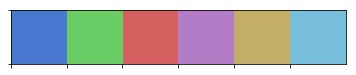

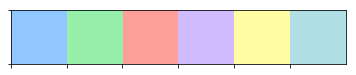

In [188]:
sns.palplot(sns.color_palette('muted'))
sns.palplot(sns.color_palette('pastel'))

### Get better names for Gordon ROIs

In [189]:
parcels=pd.read_excel('Parcels.xlsx')

def whereami(coords):
    where_res = ! module load afni; whereami {coords} -lpi -space MNI -atlas CA_ML_18_MNIA -max_areas 1 -tab
    return where_res

pnames = []
for coord in parcels.loc[:, 'Centroid (MNI)']:
    pnames.append(whereami(coord))
    
final_pns = []
for pn in pnames:
    for line in pn:
        if 'CA_ML_18_MNIA' in line:
            final_pns.append(line.split('\t')[2].strip())

parcels['roi_name'] = 'ROI ' + parcels['ParcelID'].astype(str) + ', ' + final_pns
parcels['metric'] = parcels.Hem.str.lower() + 'hgp'+ parcels.ParcelID.astype('str')

parcels.to_csv('parcels.csv')

KeyboardInterrupt: 

In [190]:
parcels = pd.read_csv('parcels.csv', index_col = 0)

In [191]:
def make_bar_list(factors, to_plot, to_plot_sig, group_offset=1.5, left_start=0, cols = 2,
                  sig_palette=sns.color_palette('muted'), palette=sns.color_palette('pastel'),
                  error=None, group_var=None, sig_exclude=[],
                  stack=True):
    fplist = []
    left = np.zeros(len(to_plot)) + left_start
    height = 0.8
    if not stack:
        height /= len(factors)
    for i,vf in enumerate(factors):
        fdict = {'bottom': [], 'width': [], 'left':left.copy(), 'color':[], 'label': [], 'tick_label': [], 'height':height}
        if error is not None:
            fdict['xerr'] = []
        if group_var is not None:
            fdict[group_var] = []
        yoffset=0

        if group_var is not None:
            for x,df in to_plot.groupby(group_var):
                if not stack:
                    fdict['bottom'].extend(list(np.arange(len(df)) + yoffset + height * i))
                else:
                    fdict['bottom'].extend(list(np.arange(len(df)) + yoffset))
                fdict['width'].extend(list(df[vf].values))
                fdict['tick_label'].extend(list(df.label.values))
                yoffset += len(df)+group_offset
                if group_var is not None:
                    fdict[group_var].extend(list(df[group_var].values))
                labels = np.array([vf]*len(df))
                colors = np.array([palette[i]]*len(df))
                
                if vf not in sig_exclude:
                    sig_mask = df[vf].values >= to_plot_sig[vf]
                    labels[sig_mask] = 'Sig. ' + vf
                    colors[sig_mask] = sig_palette[i]
                fdict['color'].extend(list(colors))
                fdict['label'].extend(list(labels))
                if error is not None:
                    fdict['xerr'].extend(list(df[error[i]].values))
        else:
            df = to_plot
            if not stack:
                fdict['bottom'].extend(list(np.arange(len(df)) + yoffset + height * i))
            else:
                fdict['bottom'].extend(list(np.arange(len(df)) + yoffset))
            fdict['width'].extend(list(df[vf].values))
            fdict['tick_label'].extend(list(df.label.values))
            if error is not None:
                fdict['xerr'].extend(list(df[error[i]].values))
            yoffset += len(df)+group_offset
            if group_var is not None:
                fdict[group_var].extend(list(df[group_var].values))
            labels = np.array([vf]*len(df))
            colors = np.array([palette[i]]*len(df))
            if vf not in sig_exclude:
                sig_mask = df[vf].values >= to_plot_sig[vf]
                labels[sig_mask] = 'Sig. ' + vf
                colors[sig_mask] = sig_palette[i]
            fdict['color'].extend(list(colors))
            fdict['label'].extend(list(labels))
        

        fdict['width'] = np.array(fdict['width'])
        fdict['width'][fdict['width']<0] = 0

        fdf = pd.DataFrame(fdict)
        fdf['col'] = cols - 1 - pd.cut(fdf['bottom'], cols, labels = np.arange(cols)).astype(int)
        if group_var is not None:
            fdf = fdf.merge(pd.DataFrame(fdf.groupby(group_var).col.max()).reset_index(), on=group_var, suffixes=['_bad','']).drop('col_bad', axis=1)
        fplist.append(fdf)
        yoffset += group_offset
        if stack:
            left += np.array(fdict['width'])
    return fplist

In [192]:
to_plot = to_plot.merge(parcels.loc[:,['metric','roi_name']])

In [193]:
uncorlist = make_bar_list(varex_factors, to_plot, to_plot_sig, cols = 3, group_var='site_varex_mean')
cblist = make_bar_list(cb_factors, to_plot, to_plot_sig_cb, left_start = 18, cols = 3, group_var='site_varex_mean')
for i,uc in enumerate(uncorlist):
    uncorlist[i] = uc.merge(to_plot.loc[:, ['roi_name','site_varex_mean']].drop_duplicates(), how='left', on='site_varex_mean')
for i,cb in enumerate(cblist):
    cblist[i] = cb.merge(to_plot.loc[:, ['roi_name','site_varex_mean']].drop_duplicates(), how='left', on='site_varex_mean')

In [194]:
to_plot.loc[:, ['roi_name','site_varex_mean']].drop_duplicates()

roi_name  site_varex_mean
0                               ROI 138, Left Lingual Gyrus        11.995789
8                                     ROI 307, Right Cuneus         8.970831
16                           ROI 175, Right Calcarine Gyrus         8.443678
24                             ROI 141, Left Fusiform Gyrus         8.239441
32                             ROI 308, Right Lingual Gyrus         7.912466
40                            ROI 298, Right Fusiform Gyrus         7.150723
48                             ROI 15, Left Calcarine Gyrus         7.026610
56                  ROI 166, Right Superior Occipital Gyrus         4.463352
62                                     ROI 137, Left Cuneus         4.245490
69                             ROI 131, Left Fusiform Gyrus         4.013709
73                     ROI 5, Left Superior Occipital Gyrus         3.719418
78                             ROI 309, Right Lingual Gyrus         3.674065
83                               ROI 20, Left Lingual Gyrus         2.358441
85                             ROI 16, Left Calcarine Gyrus         2.295022
87                               ROI 17, Left Lingual Gyrus         2.087634
92                             ROI 176, Right Lingual Gyrus         1.753642
93                             ROI 169, Right Lingual Gyrus         1.701462
94                           ROI 174, Right Calcarine Gyrus         1.308224
95                     ROI 229, Right Middle Temporal Gyrus         1.139966
96                             ROI 143, Left Fusiform Gyrus         0.642746
97                            ROI 313, Right Fusiform Gyrus         0.434748
99   ROI 275, Right Inferior Frontal Gyrus (p. Opercularis)         0.262679
100                              ROI 248, Right Insula Lobe         0.209629

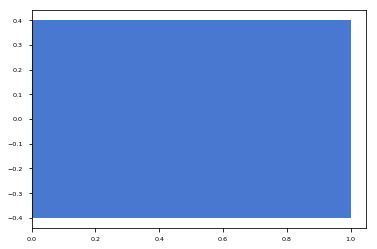

In [195]:
fig,ax = plt.subplots(1)
sig_palette=sns.color_palette('muted')[0:len(varex_factors)]
palette=sns.color_palette('pastel')[0:len(varex_factors)]
bottom = np.zeros(len(varex_factors)*2)
width = np.ones(len(varex_factors)*2)
leg_labels = []
colors = []
for i,vf in enumerate(varex_factors):
    if 'ag' not in vf.lower():
        colors.append(sig_palette[i])
        leg_labels.append('Sig. '+vf)
    leg_labels.append(vf)
    colors.append(palette[i])
    
# Change name of site to scanner
leg_labels[5] = 'Scanner'
leg_labels[4] = 'Sig. Scanner'
leg_bar = ax.barh(bottom, width, color=colors, label=leg_labels)

In [196]:
sns.set_context('paper',font_scale = 0.8 )

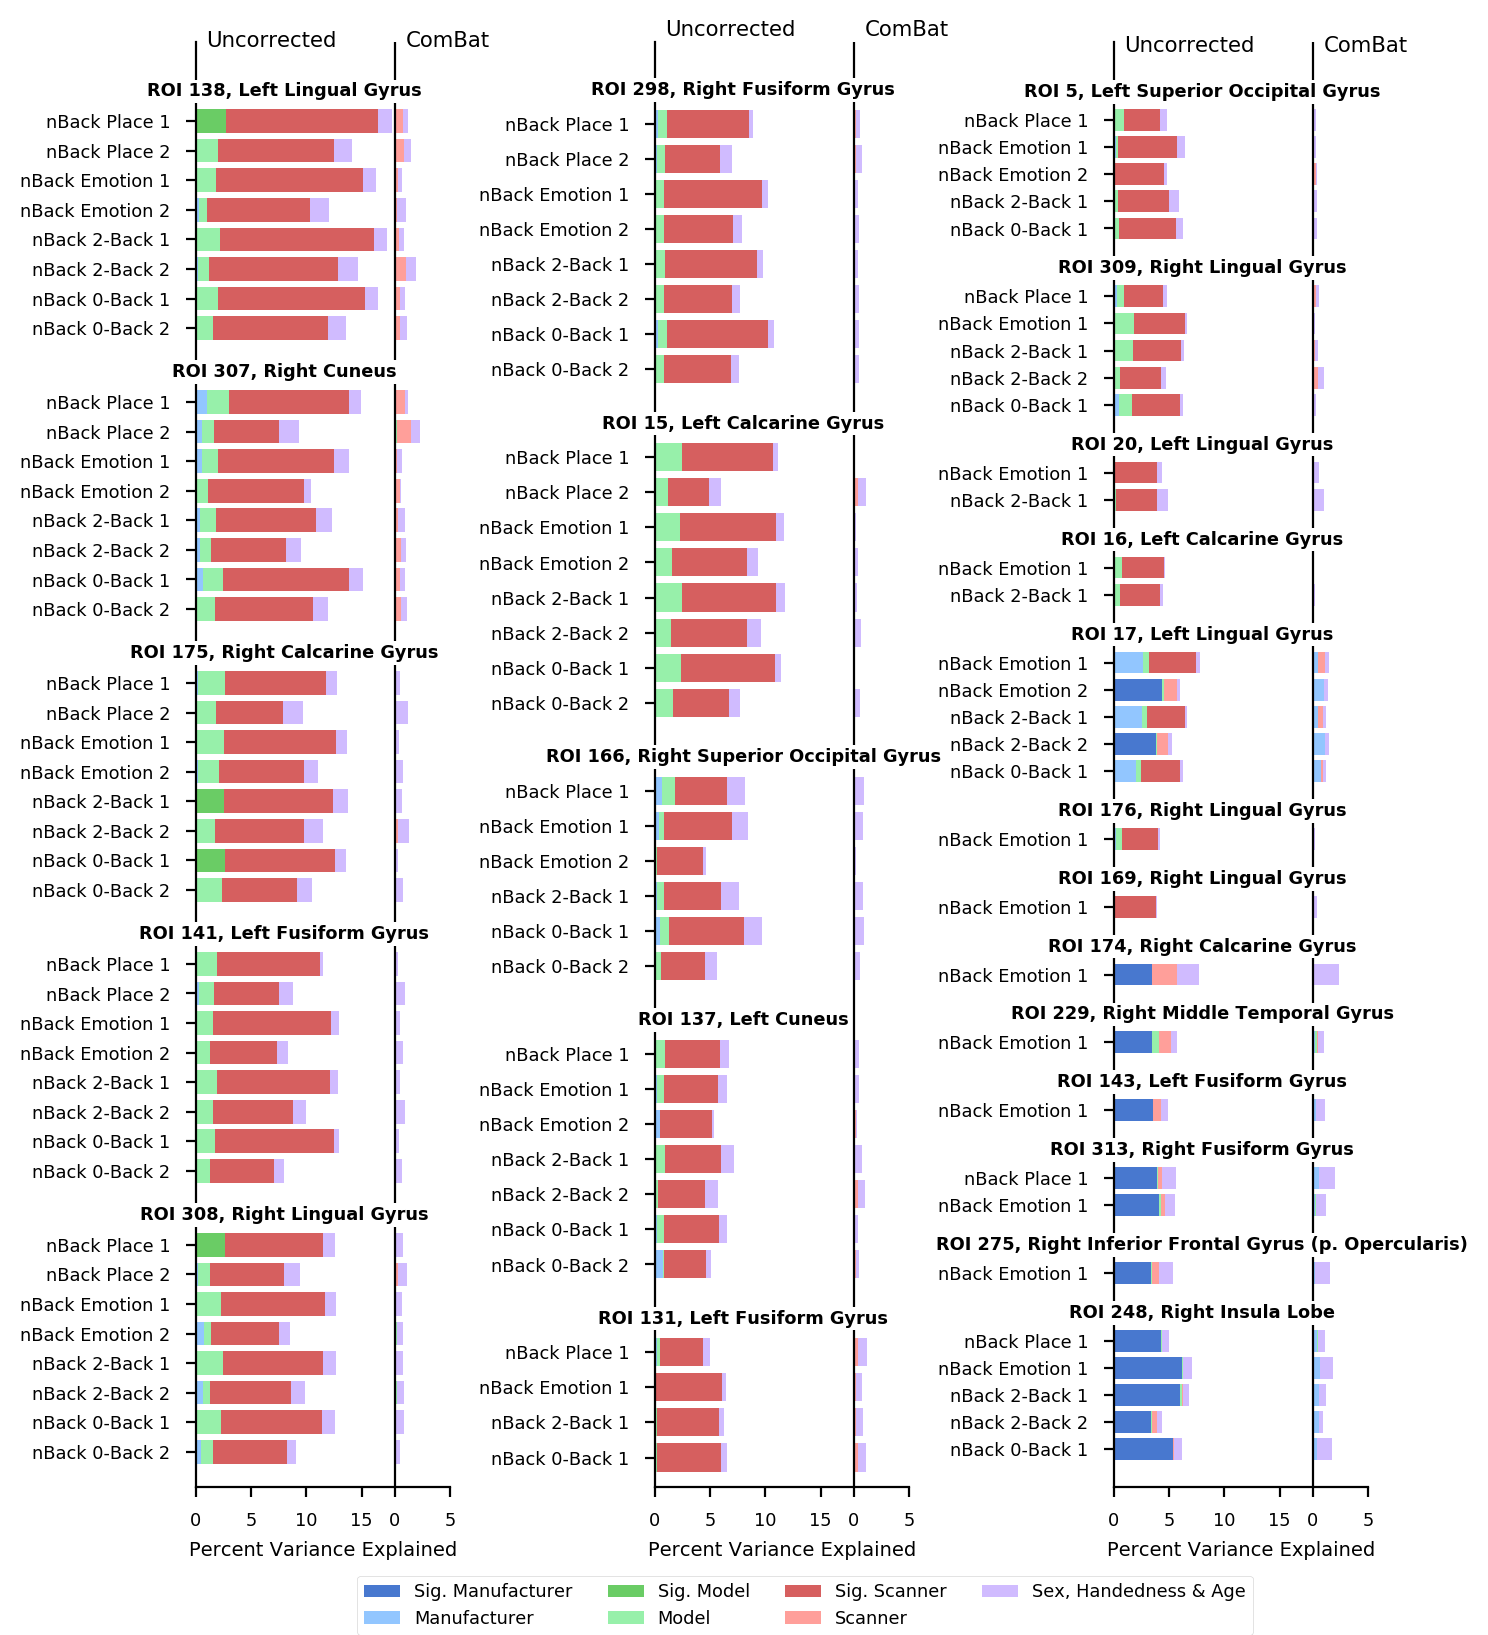

In [197]:

fig, axes = plt.subplots(1, 3, figsize=(7,8), dpi=200)

for col in np.arange(len(axes)):
    ax = axes[col]
    plot_num = 0
    for uc, cb in zip(uncorlist, cblist):
        if plot_num == 0:
            barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'tick_label', 'width']].to_dict('list')
        else:
            barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'width']].to_dict('list')
        cb_barh_dict = cb.loc[cb.col == col, ['bottom', 'color', 'left', 'width']].to_dict('list')

        names = uc.loc[uc.col == col, ['roi_name']]
        _plot = ax.barh(**barh_dict)
        _plot = ax.barh(**cb_barh_dict)
    name_df = uc.loc[uc.col == col, ['bottom', 'roi_name']].groupby('roi_name').max().reset_index()
    for ii, row in name_df.iterrows():
        _text = ax.text(8, row.bottom + 0.7, row.roi_name, va='bottom', ha='center', fontsize='small', weight='bold',
                        bbox=dict(facecolor='white', alpha=1, pad=1, lw=0))
    yb,yt = ax.get_ylim()
    _vl = ax.vlines(18, yb,yt, lw=0.8)
    _lim = ax.set_ylim((yb,yt))
    t = ax.set_xticks([0,5,10,15,18, 23])
    _tl = ax.set_xticklabels([0,5,10,15,0, 5])
    _ylims = ax.set_ylim((yb+1.5, yt))
    _t = ax.text(1, name_df.bottom.max() + 2.5, 'Uncorrected')
    _t = ax.text(19, name_df.bottom.max() + 2.5, 'ComBat')
    _t = ax.set_xlabel('Percent Variance Explained')
    
    #for tl in ax.get_yticklabels():
    #    _tl = tl.set_weight('normal')

fig.tight_layout()
fig.legend(leg_bar, leg_labels, loc=(0.24,0), ncol=4 )    
fig.subplots_adjust(bottom = 0.08)

sns.despine(fig)

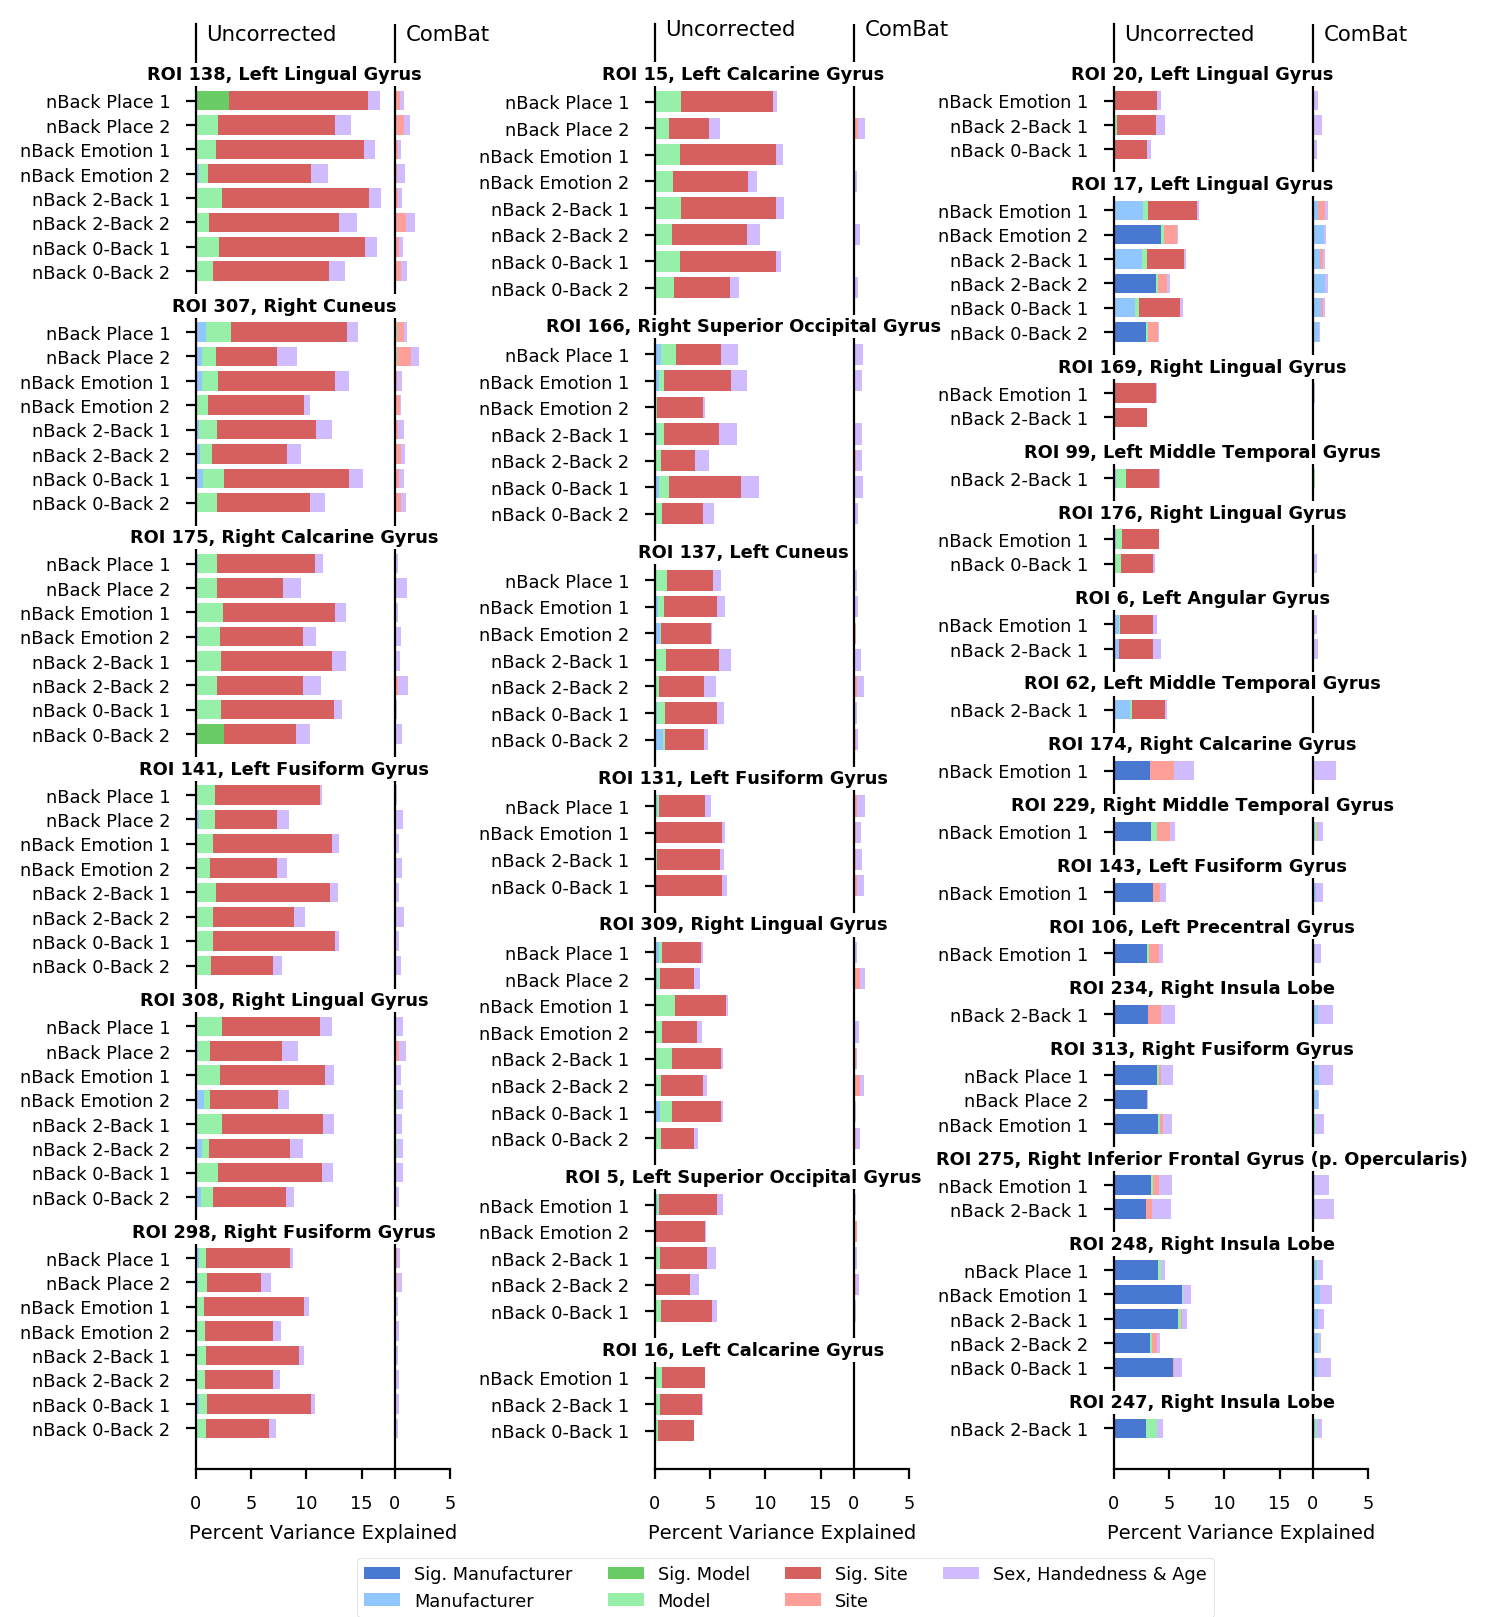

In [968]:

fig, axes = plt.subplots(1, 3, figsize=(7,8), dpi=200)

for col in np.arange(len(axes)):
    ax = axes[col]
    plot_num = 0
    for uc, cb in zip(uncorlist, cblist):
        if plot_num == 0:
            barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'tick_label', 'width']].to_dict('list')
        else:
            barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'width']].to_dict('list')
        cb_barh_dict = cb.loc[cb.col == col, ['bottom', 'color', 'left', 'width']].to_dict('list')

        names = uc.loc[uc.col == col, ['roi_name']]
        _plot = ax.barh(**barh_dict)
        _plot = ax.barh(**cb_barh_dict)
    name_df = uc.loc[uc.col == col, ['bottom', 'roi_name']].groupby('roi_name').max().reset_index()
    for ii, row in name_df.iterrows():
        _text = ax.text(8, row.bottom + 0.7, row.roi_name, va='bottom', ha='center', fontsize='small', weight='bold',
                        bbox=dict(facecolor='white', alpha=1, pad=1, lw=0))
    yb,yt = ax.get_ylim()
    _vl = ax.vlines(18, yb,yt, lw=0.8)
    _lim = ax.set_ylim((yb,yt))
    t = ax.set_xticks([0,5,10,15,18, 23])
    _tl = ax.set_xticklabels([0,5,10,15,0, 5])
    _ylims = ax.set_ylim((yb+1.5, yt))
    _t = ax.text(1, name_df.bottom.max() + 2.5, 'Uncorrected')
    _t = ax.text(19, name_df.bottom.max() + 2.5, 'ComBat')
    _t = ax.set_xlabel('Percent Variance Explained')
    
    #for tl in ax.get_yticklabels():
    #    _tl = tl.set_weight('normal')

fig.tight_layout()
fig.legend(leg_bar, leg_labels, loc=(0.24,0), ncol=4 )    
fig.subplots_adjust(bottom = 0.08)

sns.despine(fig)

In [198]:


cm_ind = (mean_cnt_var.mfg_varex >= sig_df.mfg_varex) | (mean_cnt_var.model_varex >= sig_df.model_varex) | (mean_cnt_var.site_varex >= sig_df.site_varex)

mean_cnt_var['label'] = mean_cnt_var.contrast.str.split('-').str[0] + ' ' + mean_cnt_var.contrast.str.replace('contrast', '').str.replace('reward', 'Rewd').str.replace('small', 'Sm').str.replace('large', 'Lg').str.replace('neutral', 'Neut').str.replace('anticipation', 'Ant').str.replace('-any', '').str.replace('correct', 'cor').str.replace('-of', '').str.split('-').str[1:].str.join(' ').str.title().str.replace('Versus', 'v') + ' ' + mean_cnt_var.run.str.split('.').str[0].str[-1]
to_plot = mean_cnt_var.loc[cm_ind,:].sort_values([  'site_varex_mean','contrast', 'run' ], ascending=[False, True, False]).reset_index(drop=True)
to_plot = to_plot.rename(columns={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Sex, Handedness & Age'})
to_plot_sig = sig_df.rename(index={'mfg_varex': 'Manufacturer','model_varex': 'Model','site_varex': 'Site','agh_varex': 'Sex, Handedness & Age'})
to_plot_sig_cb = cb_sig_df.rename(index={'mfg_varex': 'mfg_varex_cb','model_varex': 'model_varex_cb','site_varex': 'site_varex_cb','agh_varex': 'agh_varex_cb'})

In [199]:
to_plot = to_plot.merge(parcels.loc[:,['metric','roi_name']])

In [200]:
uncorlist = make_bar_list(varex_factors, to_plot, to_plot_sig, cols = 3, group_var='site_varex_mean')
cblist = make_bar_list(cb_factors, to_plot, to_plot_sig_cb, left_start = 18, cols = 3, group_var='site_varex_mean')
for i,uc in enumerate(uncorlist):
    uncorlist[i] = uc.merge(to_plot.loc[:, ['roi_name','site_varex_mean']].drop_duplicates(), how='left', on='site_varex_mean')
for i,cb in enumerate(cblist):
    cblist[i] = cb.merge(to_plot.loc[:, ['roi_name','site_varex_mean']].drop_duplicates(), how='left', on='site_varex_mean')

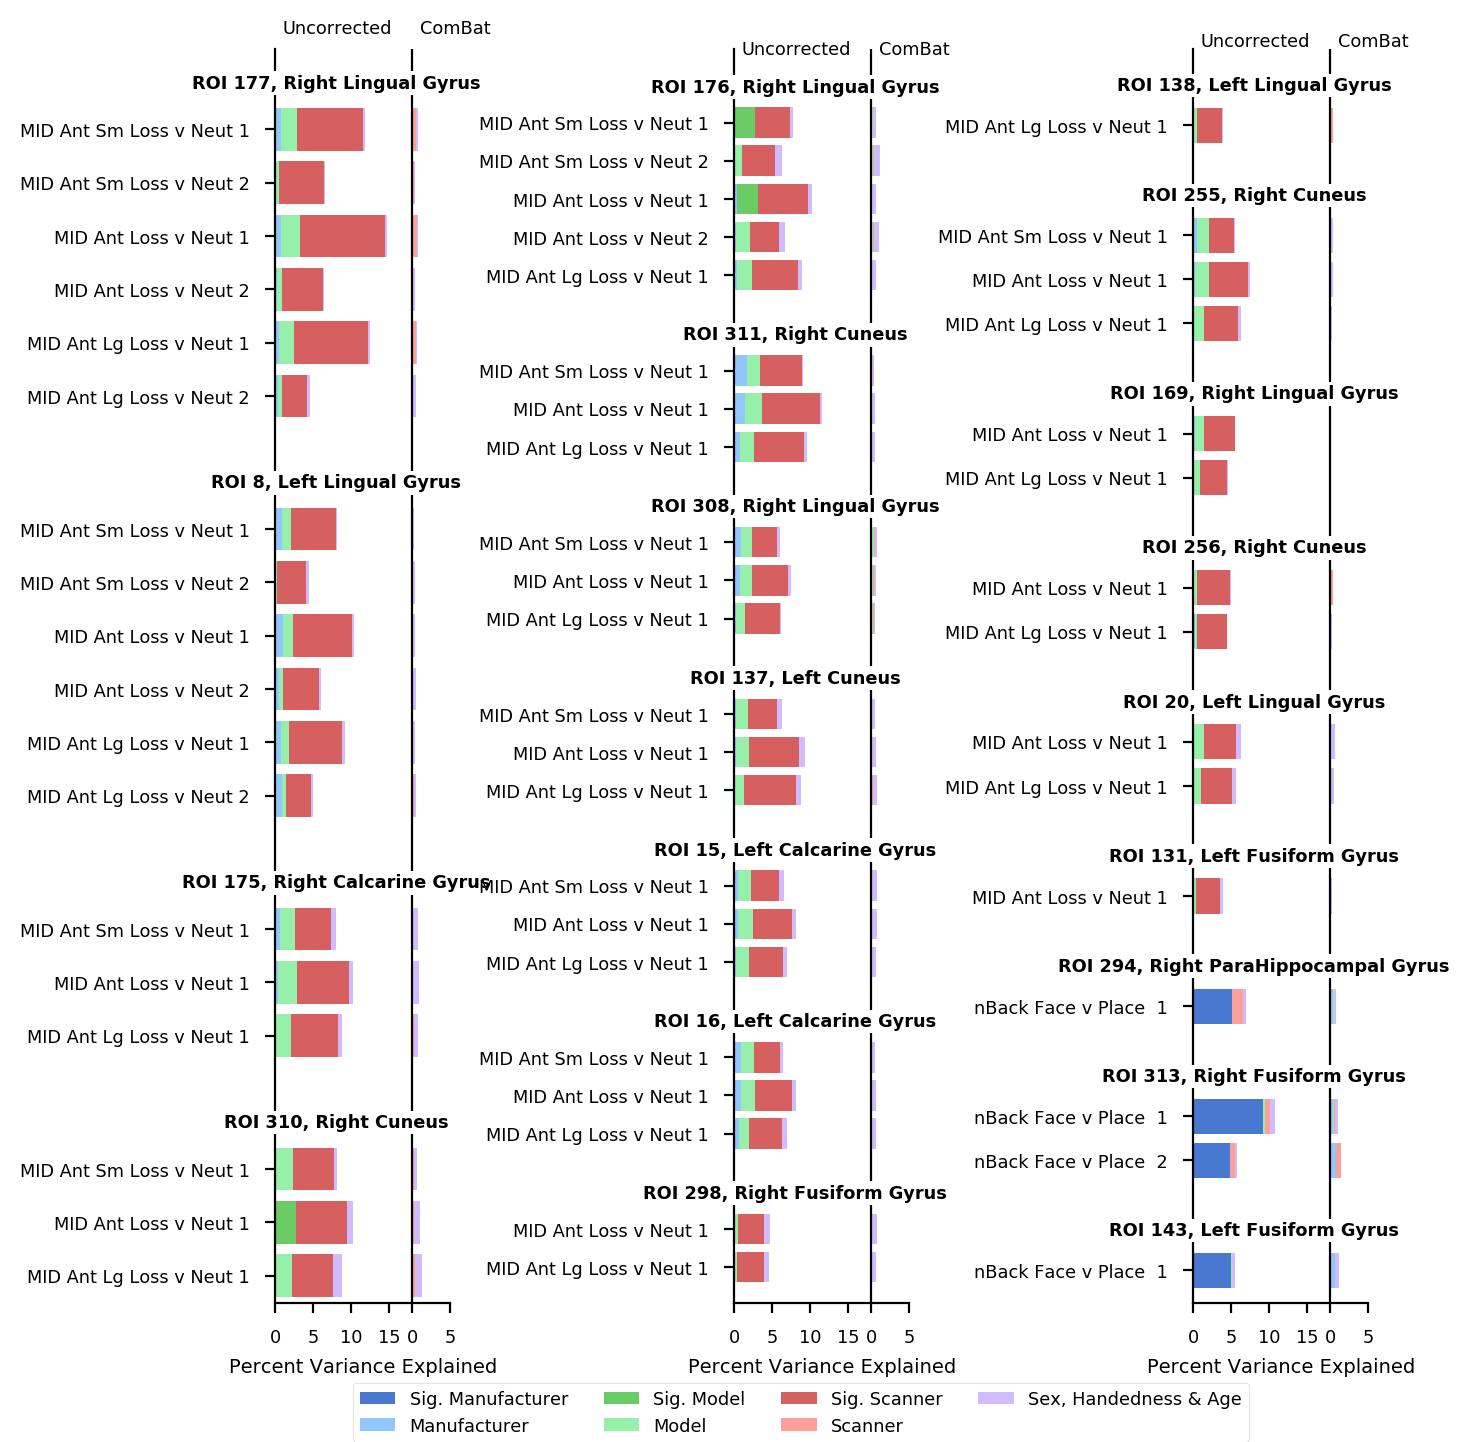

In [203]:

fig, axes = plt.subplots(1, 3, figsize=(7,7), dpi=200)

for col in np.arange(len(axes)):
    ax = axes[col]
    for uc, cb in zip(uncorlist, cblist):
        barh_dict = uc.loc[uc.col == col, ['bottom', 'color', 'left', 'tick_label', 'width']].to_dict('list')
        cb_barh_dict = cb.loc[cb.col == col, ['bottom', 'color', 'left', 'tick_label', 'width']].to_dict('list')

        names = uc.loc[uc.col == col, ['roi_name']]
        _plot = ax.barh(**barh_dict)
        _plot = ax.barh(**cb_barh_dict)
    name_df = uc.loc[uc.col == col, ['bottom', 'roi_name']].groupby('roi_name').max().reset_index()
    for ii, row in name_df.iterrows():
        _text = ax.text(8, row.bottom + 0.7, row.roi_name, va='bottom', ha='center', fontsize='small', weight='bold',
                        bbox=dict(facecolor='white', alpha=1, pad=1, lw=0))
    yb,yt = ax.get_ylim()
    _vl = ax.vlines(18, yb,yt, lw=0.8)
    _lim = ax.set_ylim((yb,yt))
    t = ax.set_xticks([0,5,10,15,18, 23])
    _tl = ax.set_xticklabels([0,5,10,15,0, 5])
    _ylims = ax.set_ylim((yb+1, yt))
    _t = ax.text(1, name_df.bottom.max() + 1.8, 'Uncorrected', fontsize="small")
    _t = ax.text(19, name_df.bottom.max() + 1.8, 'ComBat', fontsize="small")
    _t = ax.set_xlabel('Percent Variance Explained')
fig.tight_layout()
fig.legend(leg_bar, leg_labels, loc=(0.24,0), ncol=4 )    
fig.subplots_adjust(bottom = 0.085)

sns.despine(fig)

# For sig n-back conditions are there consistent variables

In [657]:
sig_coef = np.array(list(crt_mod_res.loc[crt_mod_res.contrast.isin(vsig_conds) & (crt_mod_res.name == "normal") & (crt_mod_res.pn == 0), 'coef'].values))

In [658]:
coef_perms = crt_mod_res.loc[crt_mod_res.contrast.isin(vsig_conds) & (crt_mod_res.name == "normal"), ['pn', 'coef']].groupby('pn')

In [659]:
coef_ts = []
coef_mean = []
for pn, df in coef_perms:
    coef_ts.append(stats.ttest_1samp(np.array(list(df.coef.values)), 0)[0])
    coef_mean.append(sig_coef.mean(0))
    print(pn, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [660]:
coef_ts = np.array(coef_ts[:-2])
coef_mean = np.array(coef_mean[:-2])

In [661]:
sig_coef.shape

(600, 7, 334)

In [733]:
t_thresh = np.percentile(np.abs(coef_ts).max(-1).max(-1), [99.9])

In [734]:
t_thresh

array([ 78.61041371])

In [735]:
# Load a dataframe and get the labels for cols and rows
raw_df = pd.read_pickle('swarm_dir/crt_nb_nBack-0-back-condition_RUN1.pkz')  

In [736]:
base_meta_cols = ['contrast', 'fmri_beta_gparc_numtrs', 'fmri_beta_gparc_tr', 'lmt_run', 
                  'mid_beta_seg_dof', 'task', 'collection_id', 'dataset_id', 'subjectkey',
                  'src_subject_id', 'interview_date', 'interview_age',
                  'gender', 'event_name', 'visit', 'rsfm_tr', 'eventname',
                  'rsfm_nreps', 'rsfm_numtrs', 'pipeline_version',  'scanner_manufacturer_pd',
                  'scanner_type_pd','deviceserialnumber', 'magnetic_field_strength',
                  'procdate', 'collection_title', 'promoted_subjectkey', 'study_cohort_name','ehi_y_ss_scoreb', '_merge', 'qc_ok', 'age_3mos', 'index', 'label']
meta_cols = raw_df.columns[raw_df.columns.isin(base_meta_cols)].values
metric_cols = raw_df.columns[~raw_df.columns.isin(base_meta_cols)].values

In [737]:
with open('swarm_dir/yfit_crt.pkz', 'rb') as h:
    ymapper = pickle.load(h)

In [738]:
raw_df['label'] = ymapper.transform(raw_df)

In [739]:
ts_df = raw_df.groupby('label')[['scanner_manufacturer_pd',
                  'scanner_type_pd','deviceserialnumber']].first().reset_index()

In [740]:
sig_vals = coef_mean[0][:,(np.abs(coef_ts[0])>=t_thresh).sum(0)>1]
sig_vals[(np.abs(coef_ts[0][:,(np.abs(coef_ts[0])>=t_thresh).sum(0)>1])<t_thresh)] = np.nan
sig_cols = metric_cols[(np.abs(coef_ts[0])>=t_thresh).sum(0)>1]

In [741]:
sig_df = pd.DataFrame(sig_vals, columns = sig_cols)

In [742]:
label_sig_df = pd.concat([ts_df, sig_df], axis =1).sort_values(['scanner_manufacturer_pd',
                  'scanner_type_pd','deviceserialnumber'])

In [743]:
# Drop rows wit no sig ROIs
label_sig_df = label_sig_df.loc[pd.notnull(label_sig_df.loc[:, ['lhgp138','rhgp175', 'rhgp307']]).sum(1)!=0, :]

In [744]:
from nilearn import image as nli

In [745]:
parcels = nli.load_img('Parcels_MNI_333.nii')

In [746]:
sig_df.columns

Index(['lhgp138', 'rhgp175', 'rhgp307'], dtype='object')

In [747]:
parcel_cols = ['lhgp138',
       'rhgp175', 'rhgp307']
parcel_num = [int(pc.split('p')[-1]) for pc in parcel_cols]
sig_parcels = sig_df.loc[:,parcel_cols]
sig_parcels.columns = parcel_num

In [748]:
par_dat = parcels.get_data()

In [749]:
site_imgs = []
for label,row in sig_parcels.iterrows():
    site_nii = np.zeros(par_dat.shape)
    for roi,value in row.iteritems():
        if pd.notnull(value):
            site_nii[par_dat == roi] = value
    site_img = nli.new_img_like(parcels, site_nii, parcels.affine, copy_header=True)
    site_img.to_filename('crt_%02d_coefs.nii.gz'%label)
    site_imgs.append(site_img)


In [750]:
from nilearn import plotting as nlp

In [751]:
sns.set_context('paper',font_scale = 0.8 )

In [752]:
label_sig_df['num'] = label_sig_df.groupby('scanner_type_pd').label.transform(lambda x: range(len(x))).astype(str)

In [753]:
label_sig_df

label scanner_manufacturer_pd  scanner_type_pd deviceserialnumber  \
6      6      GE MEDICAL SYSTEMS  DISCOVERY MR750       HASHc3bf3d9c   
0      0                 SIEMENS           Prisma       HASH11ad4ed5   
1      1                 SIEMENS       Prisma_fit       HASH1314a204   

    lhgp138   rhgp175   rhgp307 num  
6       NaN -0.393882 -0.490253   0  
0  0.641665  0.380016  0.522808   0  
1 -0.412743       NaN       NaN   0

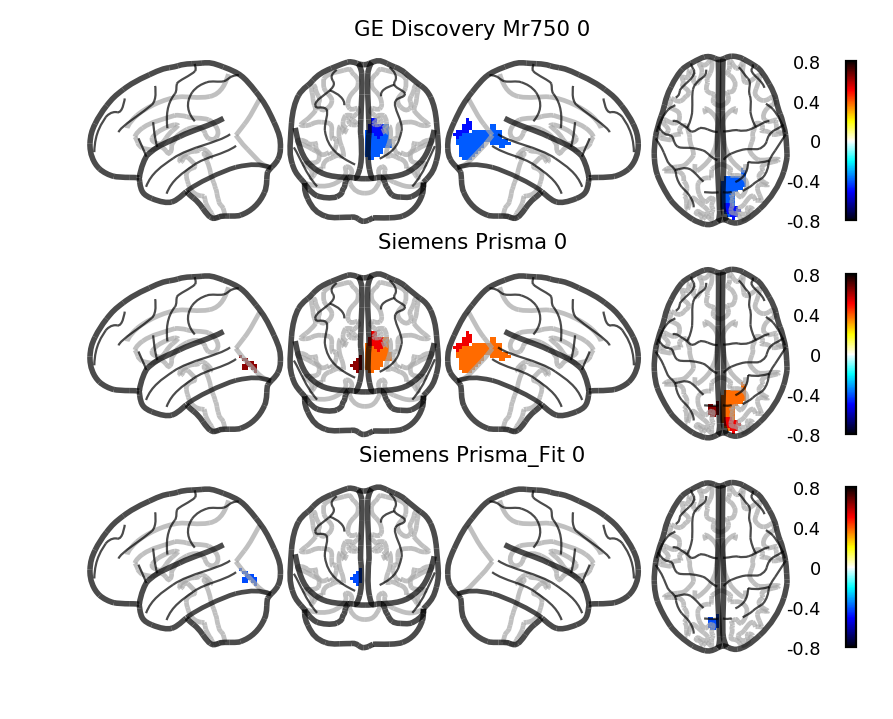

In [754]:
fig,axs = plt.subplots(len(label_sig_df), figsize=(5,4), dpi=200)
ii = 0
for rn, row in label_sig_df.iterrows():
    
    if row.scanner_manufacturer_pd == 'GE MEDICAL SYSTEMS':
        mfg = 'GE'
    else:
        mfg = row.scanner_manufacturer_pd.split()[0].title()
    title = mfg + ' ' + row.scanner_type_pd.title() + ' ' + row.num
    nlp.plot_glass_brain(site_imgs[rn], plot_abs=False,figure=fig, axes=axs[ii],vmin=-0.8, vmax=0.8, colorbar=True, annotate=False, display_mode='lyrz', symmetric_cbar=True)
    axs[ii].set_title(title)
    ii += 1

/data/nielsond/python/envs/py3/lib/python3.6/site-packages/nilearn/plotting/displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


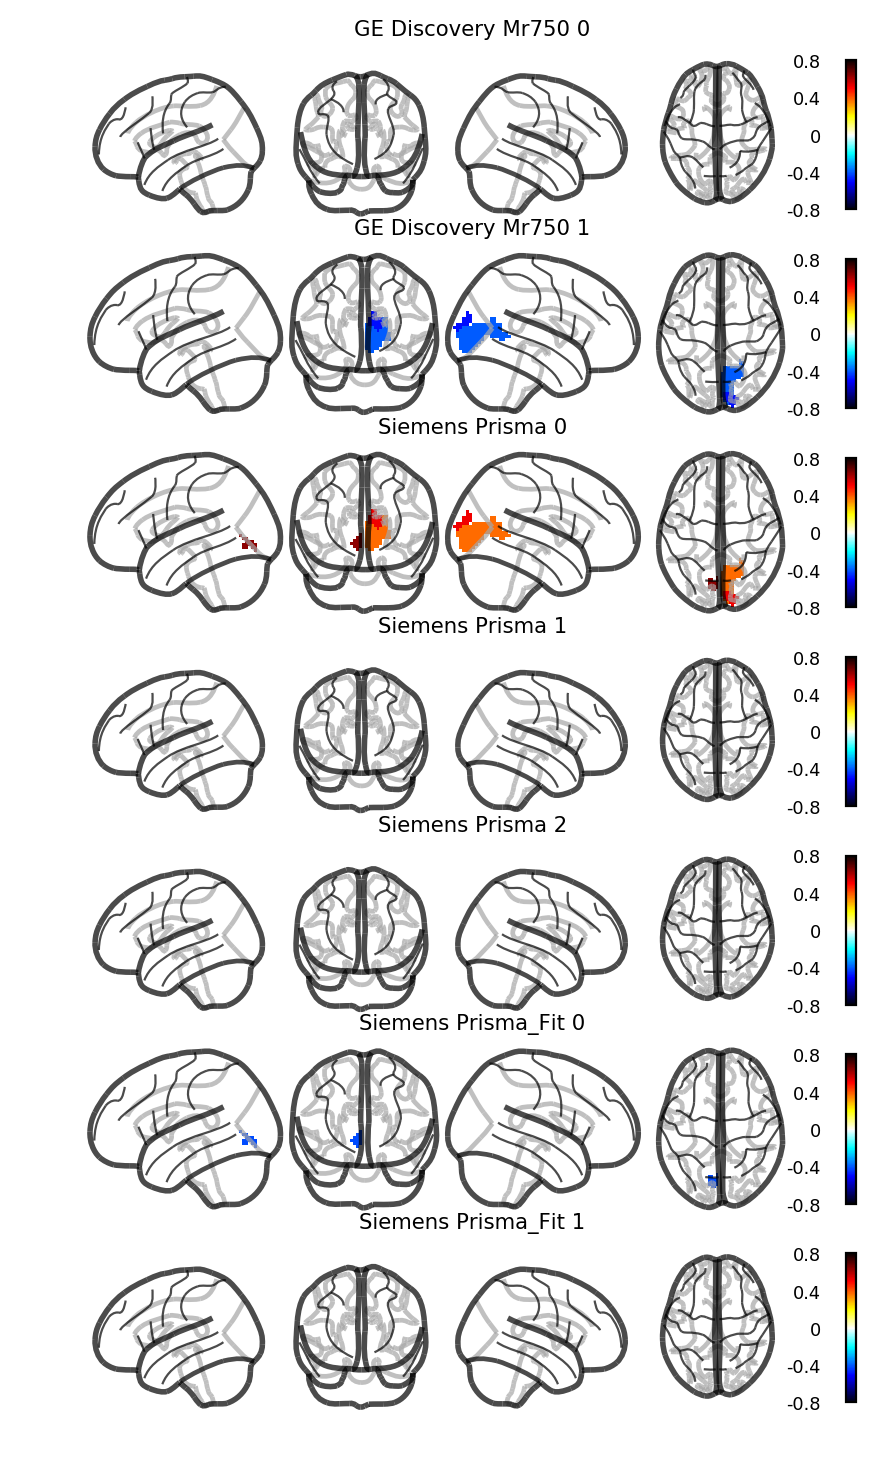

In [427]:
fig,axs = plt.subplots(len(label_sig_df), figsize=(5,9), dpi=200)
ii = 0
for rn, row in label_sig_df.iterrows():
    
    if row.scanner_manufacturer_pd == 'GE MEDICAL SYSTEMS':
        mfg = 'GE'
    else:
        mfg = row.scanner_manufacturer_pd.split()[0].title()
    title = mfg + ' ' + row.scanner_type_pd.title() + ' ' + row.num
    nlp.plot_glass_brain(site_imgs[rn], plot_abs=False,figure=fig, axes=axs[ii],vmin=-0.8, vmax=0.8, colorbar=True, annotate=False, display_mode='lyrz', symmetric_cbar=True)
    axs[ii].set_title(title)
    ii += 1

AttributeError: 'Series' object has no attribute 'num'

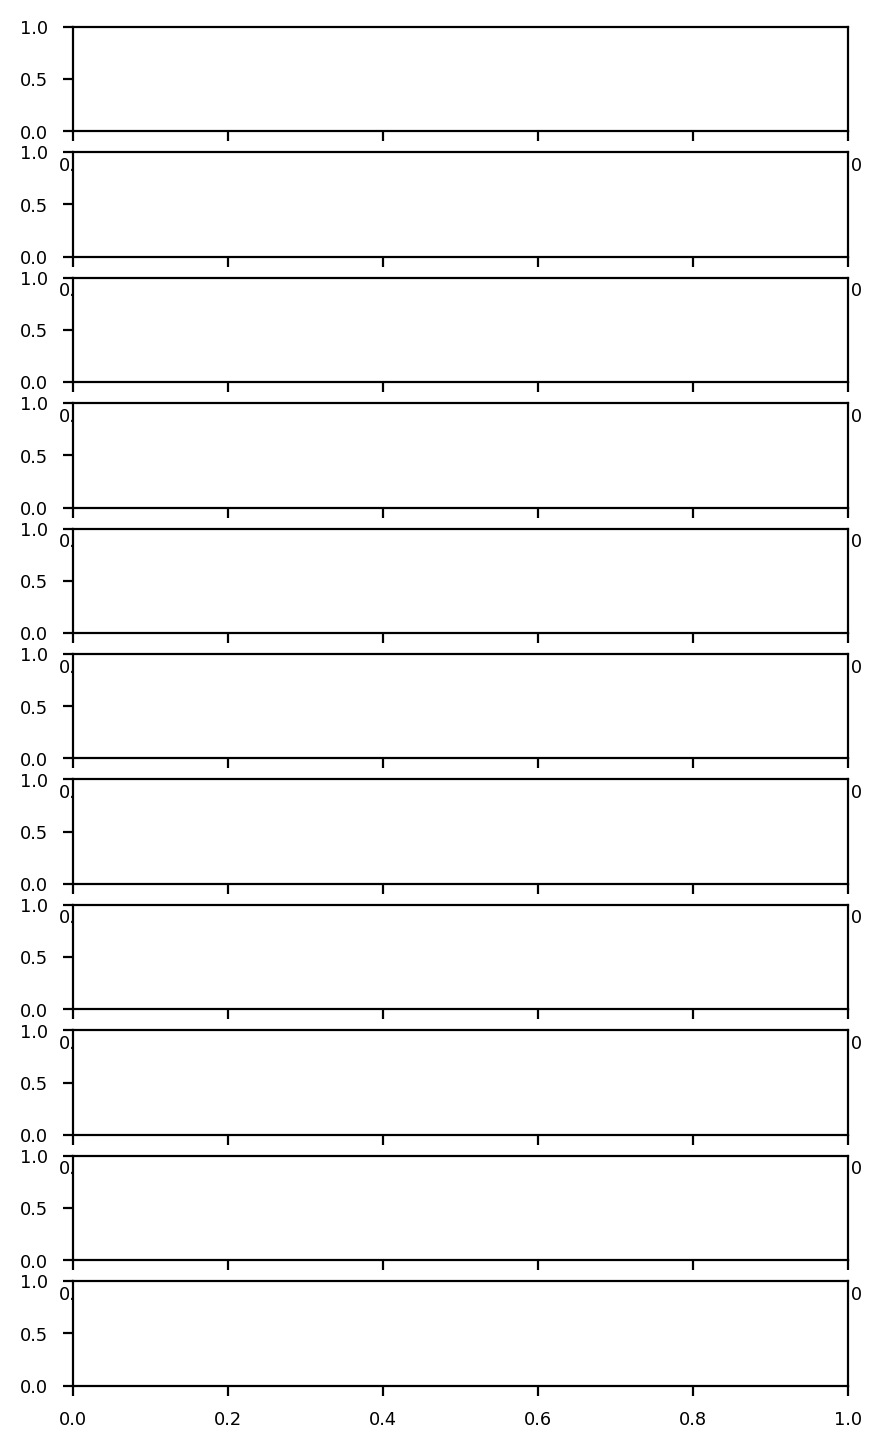

In [656]:
fig,axs = plt.subplots(len(label_sig_df), figsize=(5,9), dpi=200)
ii = 0
for rn, row in label_sig_df.iterrows():
    
    if row.scanner_manufacturer_pd == 'GE MEDICAL SYSTEMS':
        mfg = 'GE'
    else:
        mfg = row.scanner_manufacturer_pd.split()[0].title()
    title = mfg + ' ' + row.scanner_type_pd.title() + ' ' + row.num
    nlp.plot_glass_brain(site_imgs[rn], plot_abs=False,figure=fig, axes=axs[ii],vmin=-0.8, vmax=0.8, colorbar=True, annotate=False, display_mode='lyrz', symmetric_cbar=True)
    axs[ii].set_title(title)
    ii += 1

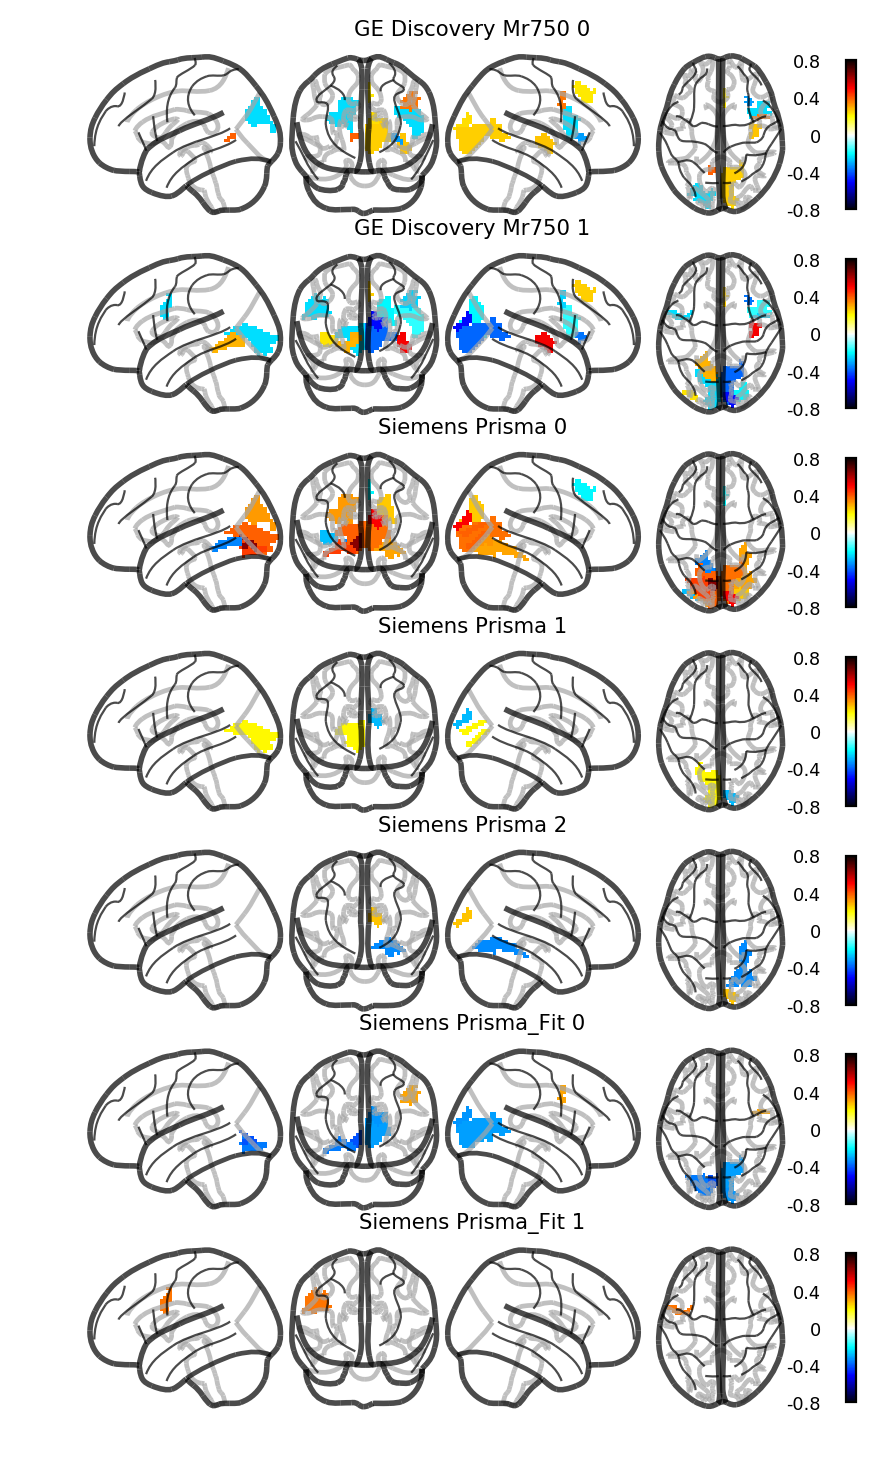

In [849]:
fig,axs = plt.subplots(len(label_sig_df), figsize=(5,9), dpi=200)
ii = 0
for rn, row in label_sig_df.iterrows():
    
    if row.scanner_manufacturer_pd == 'GE MEDICAL SYSTEMS':
        mfg = 'GE'
    else:
        mfg = row.scanner_manufacturer_pd.split()[0].title()
    title = mfg + ' ' + row.scanner_type_pd.title() + ' ' + row.num
    nlp.plot_glass_brain(site_imgs[rn], plot_abs=False,figure=fig, axes=axs[ii],vmin=-0.8, vmax=0.8, colorbar=True, annotate=False, display_mode='lyrz', symmetric_cbar=True)
    axs[ii].set_title(title)
    ii += 1

# Confusion matrices

In [ ]:
def get_cfns(df, name):
    cfns = df.query('pn == 0 & name == @name').cfn.values
    cfns = np.array([c for c in cfns])
    perm_cfns = []
    for pn in df.pn.unique():
        if pn !=0:
            tmp = df.query('pn == @pn & name == @name').cfn.values
            perm_cfns.append(np.array([c for c in tmp]))

    perm_cfns = np.array(perm_cfns)
    return cfns, perm_cfns

import itertools
def get_collapsed_perms(cfns, perm_cfns):
    model_cfns = np.array([collapse_group(cfn, model_lut, model_order, normalize=False) for cfn in cfns])
    #model_perm_cfns = np.array([[collapse_group(pcfn, model_lut, model_order, normalize=False) for pcfn in pc] for pc in perm_cfns])
    mfg_cfns = np.array([collapse_group(cfn, mfg_lut, mfg_order, normalize=False) for cfn in cfns])
    #mfg_perm_cfns = np.array([[collapse_group(pcfn, mfg_lut, mfg_order, normalize=False) for pcfn in pc] for pc in perm_cfns])
    
    
    #model_cfns_norm = np.array([collapse_group(cfn, model_lut, model_order, normalize=True) for cfn in cfns])
    model_perm_cfns_norm = np.array([[collapse_group(pcfn, model_lut, model_order, normalize=True) for pcfn in pc] for pc in perm_cfns])
    #mfg_cfns_norm = np.array([collapse_group(cfn, mfg_lut, mfg_order, normalize=True) for cfn in cfns])
    mfg_perm_cfns_norm = np.array([[collapse_group(pcfn, mfg_lut, mfg_order, normalize=True) for pcfn in pc] for pc in perm_cfns])
    
    model_cfn_signed_ps_norm = get_cfn_sig(model_cfns_norm, model_perm_cfns_norm)
    mfg_cfn_signed_ps_norm = get_cfn_sig(mfg_cfns_norm, mfg_perm_cfns_norm)
    
    return model_cfns, mfg_cfns, model_cfn_signed_ps_norm, mfg_cfn_signed_ps_norm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          signed_ps=None,
                          sig_thresh = 0.025):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.1f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        weight = 'normal'
        if signed_ps is not None:
            if np.abs(signed_ps[i, j]) < sig_thresh:
                weight = 'bold'
        if normalize == False:
            s = format(cm[i,j], fmt)
        else:
            s = format(cm[i,j], fmt)
        plt.text(j, i, s,
                 horizontalalignment="center",va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontweight=weight, size="x-small")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          numbers=False,
                          symbols=False,
                          cmap=plt.cm.Blues,
                          signed_ps=None,
                          sig_thresh = 0.025, ax=None, fig=None, colorbar=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    if ax is None:
        fig,ax = plt.subplots(1)
    if normalize:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    if colorbar:
        fig.colorbar(im)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, size="x-small")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes,  size="x-small")

    fmt = '.2f' if normalize else '.1f'
    thresh = cm.max() / 2.
    if numbers:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            weight = 'normal'
            if signed_ps is not None:
                if np.abs(signed_ps[i, j]) < sig_thresh:
                    weight = 'bold'
            if normalize == False:
                s = format(cm[i,j], fmt)
            else:
                s = format(cm[i,j], fmt)
            ax.text(j, i, s,
                     horizontalalignment="center",va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontweight=weight, size="xx-small")

    elif symbols:
        if signed_ps is not None:
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                if np.abs(signed_ps[i, j]) < sig_thresh:
                    if np.sign(1/signed_ps[i, j]) > 0:
                        s = '+'
                    elif np.sign(1/signed_ps[i, j]) < 0:
                        s = '-'
                    ax.text(j, i, s,
                             horizontalalignment="center",va="center",
                             color="white" if cm[i, j] > thresh else "black",
                             fontweight="bold")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return fig,ax, im
    
def collapse_group(cfn, group_lut, group_order, normalize=False):
    
    cfndf = pd.DataFrame(data=cfn)
    group_vals = [group_lut[ii] for ii in cfndf.index.values]
    collapsed = (cfndf
                 .assign(group=group_vals)
                 .groupby('group')
                 .sum()
                 .T
                 .assign(group=group_vals)
                 .groupby('group')
                 .sum()
                 .T
                 .loc[group_order, group_order]).values
    if normalize:
        collapsed = collapsed.astype('float') / collapsed.sum(axis=1)[:, np.newaxis]
    return collapsed

In [711]:
raw_df = pd.read_pickle('swarm_dir/crt_mid_MID-anticipation-of-large-loss-versus-neutral_RUN1.pkz')
with open('swarm_dir/yfit_crt.pkz', 'rb') as h:
    ymapper = pickle.load(h)
    
raw_df['cat_num'] = ymapper.transform(raw_df)
    
model_lut = {k:v['scanner_type_pd'] for k,v in  raw_df.groupby('cat_num')[['scanner_type_pd']].first().to_dict('index').items()}
mfg_lut = {k:v['scanner_manufacturer_pd'] for k,v in  raw_df.groupby('cat_num')[['scanner_manufacturer_pd']].first().to_dict('index').items()}

#model_order = ['Prisma', 'Prisma_fit', 'DISCOVERY MR750','Achieva dStream', 'Ingenia']
model_order = ['DISCOVERY MR750', 'Prisma', 'Prisma_fit', ]

mfg_order = ['GE MEDICAL SYSTEMS', 'SIEMENS', ]

In [712]:
cat_df = raw_df.groupby('cat_num')[['scanner_manufacturer_pd',
                  'scanner_type_pd','deviceserialnumber']].first()
cat_df['mfg'] = cat_df.scanner_manufacturer_pd
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('GE'), 'mfg'] = 'GE'
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('Philips'), 'mfg'] = 'PH'
cat_df.loc[cat_df.scanner_manufacturer_pd.str.contains('SIEMENS'), 'mfg'] = 'SM'

cat_df['mdl'] = cat_df.scanner_type_pd
cat_df.loc[cat_df.scanner_type_pd == 'Prisma', 'mdl'] = 'Prsm'
cat_df.loc[cat_df.scanner_type_pd == 'Prisma_fit', 'mdl'] = 'Pr-f'
cat_df.loc[cat_df.scanner_type_pd == 'DISCOVERY MR750', 'mdl'] = 'Dsc7'
cat_df.loc[cat_df.scanner_type_pd == 'Ingenia', 'mdl'] = 'Ingn'
cat_df.loc[cat_df.scanner_type_pd == 'Achieva dStream', 'mdl'] = 'Achv'

cat_df['num'] = cat_df.groupby(['scanner_manufacturer_pd', 'scanner_type_pd']).transform(lambda x:np.arange(len(x))).mdl.values

cat_df['hname'] = cat_df.mfg + '_' +cat_df.mdl + '_' + cat_df.num.astype('str')

cat_df['sort_key'] = 0
cat_df.loc[cat_df.mfg == 'GE', 'sort_key'] = 1
cat_df.loc[cat_df.mfg == 'SM',  'sort_key'] = 2

reo_ind = [cat_df.sort_values(['sort_key', 'scanner_manufacturer_pd',
                  'scanner_type_pd','num']).reset_index().cat_num.values][0]
classes = cat_df.sort_values(['sort_key', 'scanner_manufacturer_pd',
                  'scanner_type_pd','num']).hname.values

In [716]:
vsig_df = crt_mod_res.loc[crt_mod_res.contrast.isin(vsig_conds),:]